# 0.0. IMPORTS 

In [1]:
import numpy   as np
import pandas  as pd
import seaborn as sns
import matplotlib.pyplot as plt

import math
import datetime
import inflection
import random
import pickle
import requests
import json

from IPython.display       import Image
from scipy                 import stats
from boruta                import BorutaPy
from matplotlib.gridspec   import GridSpec

import xgboost as xgb

from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.ensemble      import RandomForestRegressor
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics       import mean_absolute_error, mean_squared_error

## 0.1. Helper Functions

In [2]:
def cramer_v( x, y ):
    
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency( cm )[0]
    
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min(kcorr-1,rcorr-1) ) )


def mean_percentage_erro( y, yhat ):
    
    return np.mean( ( y - yhat ) / y ) 

         
def mean_absolute_percentage_erro( y, yhat ):
    
    return np.mean( np.abs( ( y - yhat ) / y ) )

    
def ml_error( model_name, y, yhat ):
    
    mae  = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_erro( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name': model_name, 
                           'MAE': mae, 
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )

def cross_validation( xtraining, kfold, model_name, model, verbose=False ):
    
    mae_list  = []
    mape_list = []
    rmse_list = []

    for k in range( 1, kfold+1 ):
        
        if verbose:
            print( '\nKfold Number: {}' .format( k ) )

        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*7*6 )
        validation_end_date   = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7 )

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        xtraining = training.drop( ['date','sales'], axis=1 )
        ytraining = training['sales']
        xvalidation = validation.drop( ['date','sales'], axis=1 )
        yvalidation = validation['sales']

        # modelo
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performace
        m_result = ml_error( 'model_name', np.expm1( yvalidation ), np.expm1( yhat ) )

        # peformace of each interation
        mae_list.append( m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str )}, index=[0] )


In [3]:
sns.set_style( 'darkgrid' )
sns.set_palette( 'Paired' )

## 0.2. Loading Data

In [4]:
df_sales_raw = pd.read_csv( 'data/train.csv', low_memory=False )
df_store_raw = pd.read_csv( 'data/store.csv', low_memory=False )

# merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store' )

In [5]:
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# 1.0. Data Description

In [6]:
df1 = df_raw.copy()

## 1.1. Rename Columns

Renaming the column's name to a style "snake_case".

> Snake case (stylized as snake_case) refers to the style of writing in which each space is replaced by an underscore (_) character, and the first letter of each word written in lowercase. It is a commonly used naming convention in computing, for example for variable and subroutine names, and for filenames. (Wikipedia)

In [7]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
            'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ) )

# Rename
df1.columns = cols_new

## 1.2. Data Dimensions

In [8]:
print( 'Number of Rows: {}' .format( df1.shape[0] ) )
print( 'Number of Rows: {}' .format( df1.shape[1] ) )

Number of Rows: 1017209
Number of Rows: 18


## 1.3. Data Types

In [9]:
# changing the column "date" to a datatime64
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

Despite of being a large dataset there are lots of missing data.

In [10]:
df1.isnull().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

   - **Competition_distance** (distance in meters to the nearest competitor store):
       - I assume that, if there's NA, the store doesn't have a competition or the competitor are so far that can't be consired a competitor.
       - Approach: Put a distance much far than the max distance in this feature.
       

   - **Competition_open_since_month** (gives the approximate month of the time the nearest competitor was opened):
   
   There are at least two situations that explain why this columns are empty: 
       - **A**. The store doesn't have a near competitor. And then, there isn't an open date to competition.
       - **B**. The store has a competitor, but it's no known when it opened.
           - Might be because the competitor opend before the store open or it was opened after and wasn't registered.
       - Approach: It'll be filled to the month value from the date column.
       
       
   - **Competition_open_since_year** (gives the approximate year of the time the nearest competitor was opened)
   
   The same approach as before, but now it'll be filled with the year.
   

   - **promo2_since_week and promo2_since_year** (describes the year and calendar week when the store started participating in Promo2)
       - If it is NA, it means that the stores decided not to continue with the promo2, so this information has not been available "since when", as it has not adopted it at any time.
       - Approach: It'll be filled by year and week values from the column "date".
       
       
   - **promo_interval** (describes the consecutive intervals Promo2 is started, naming the months the promotion is started a new. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store)
       
       - Approach: It'll be filled by 0, It means that the store is not between the interval of months that the promo2 started.
       
       
   - **month_map** (new feature created)
       - It'll be filled by the month from the "date" column in string form (Jan, Feb, ..., Dec) to be compared with the "promo_interval" feature.
       
       
   - **is_promo** (new feature created)
       - Receives 1 when the store has a promotion and 0 when it doesn't.
       - Approach: if the month in the "month_map" column is between the months "Feb,May,Aug,Nov" that are in the promo_interval column it returns 1, if not, it returns 0

In [11]:
df1['competition_distance'].max()

75860.0

In [12]:
#competition_distance 
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

#competition_open_since_month    
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 ) 

#competition_open_since_year     
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 ) 

#promo2_since_week               
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 ) 

#promo2_since_year               
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 ) 
  
#promo_interval                  
df1['promo_interval'].fillna( 0, inplace=True )

#month_map
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar',4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['month_map'] = df1['date'].dt.month.map( month_map )

#is_promo
df1['is_promo'] = df1[['promo_interval','month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

Now, there isn't any missing value

In [13]:
df1.isnull().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Types

Convert the type of data after this changes done.

In [14]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( np.int64 )
df1['competition_open_since_year']  = df1['competition_open_since_year'].astype( np.int64 )

df1['promo2_since_week'] = df1['promo2_since_week'].astype( np.int64 )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( np.int64 )

## 1.7. Descriptive Statistical

Descriptive statistics to numerical and categorical variables. It might be important to have a sight of how the process is working about, And be able to see possible problems or inconsistencies in the dataset just taking a look at these numbers.

Split of two auxiliary DataFrames, a numerical and a categorical.

In [15]:
num_attributes = df1.select_dtypes( include=['int64','float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64','float64','datetime64[ns]'] )

### 1.7.1 Numerical Attributes

 - It's showed known measures of central tendency as mean and median.
 - It's showed known measures of dispersion tendency as standard deviation, min, max, range, skew and kurtosis.
 
**Skewness** Is a measure of symmetry, or more precisely, the lack of symmetry. A distribution, or data set, is symmetric if it looks the same to the left and right of the center point.

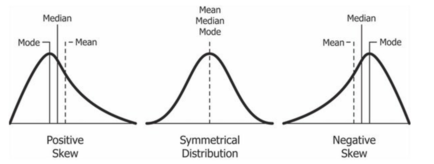

**Kurtosis** Is a measure of whether the data are heavy-tailed or light-tailed relative to a normal distribution. That is, data sets with high kurtosis tend to have heavy tails, or outliers. Data sets with low kurtosis tend to have light tails, or lack of outliers. A uniform distribution would be the extreme case.

In [16]:
c1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
c2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

c3 = pd.DataFrame( num_attributes.apply( np.std ) ).T
c4 = pd.DataFrame( num_attributes.apply( np.min ) ).T
c5 = pd.DataFrame( num_attributes.apply( np.max ) ).T
c6 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
c7 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
c8 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

metrics = pd.concat( [c4, c5, c6, c1, c2, c3, c7, c8] ).T
metrics.columns = ['min','max','range','mean','median','std','skew','kurtosis']
metrics

,min,max,range,mean,median,std,skew,kurtosis
store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


Information took to the feature "competition_distance" 

 - Skew is much high suggesting a high right asymmetry. 
 - kurtose much high tend to have heavy tails, or outliers. **(This feature was influenced by the process I've done before on step 1.5. It was put a larger distance than the max distance in this feature.)**

Together with this information, is shown with a graph, that the most amount of store that has competition has a lower distance between its competitor.

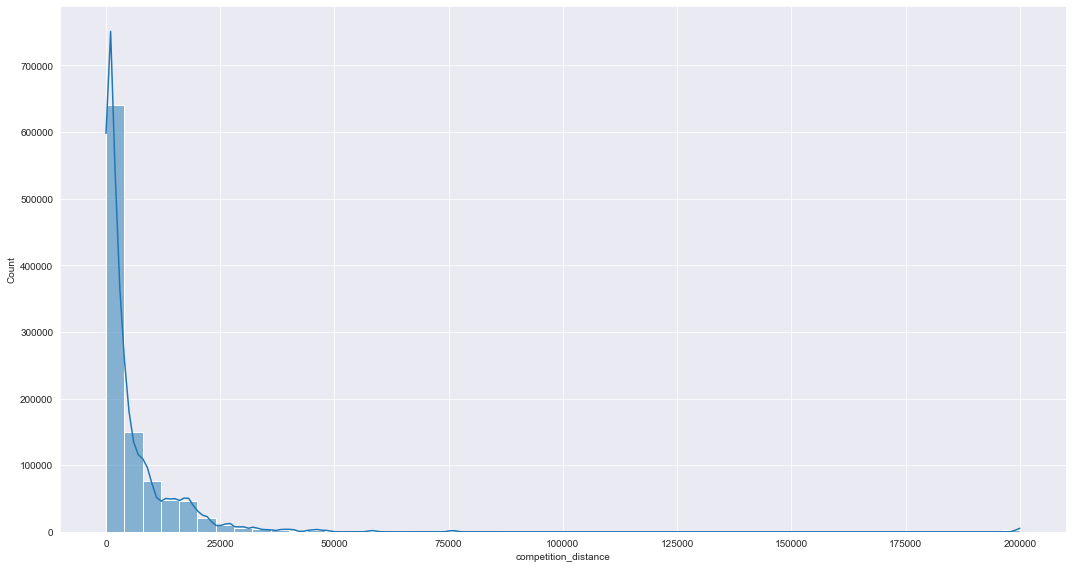

In [17]:
plt.figure( figsize=( 15, 8 ) )
sns.histplot( df1['competition_distance'], kde=True, bins=50, color=sns.color_palette('Paired')[1] )

plt.tight_layout()

### 1.7.2 Categorical Attributes

In [18]:
# unique values of each categorical feature
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

Filtering the dataset, taking out the lines that contains the day when the store is closed (sales=0) and filtering by state_holiday (state_holiday=0 means that there isn't any state_holiday).

 - **StateHoliday**: indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
 - **StoreType**:    differentiates between 4 different store models: a, b, c, d
 - **Assortment**:   describes an assortment level: a = basic, b = extra, c = extended
 
seing the graphs it's possible take some information such as:

 - The store type "b" has its median much higher than another one's and much outliers as well.
 - The state holiday are much similar among each other.

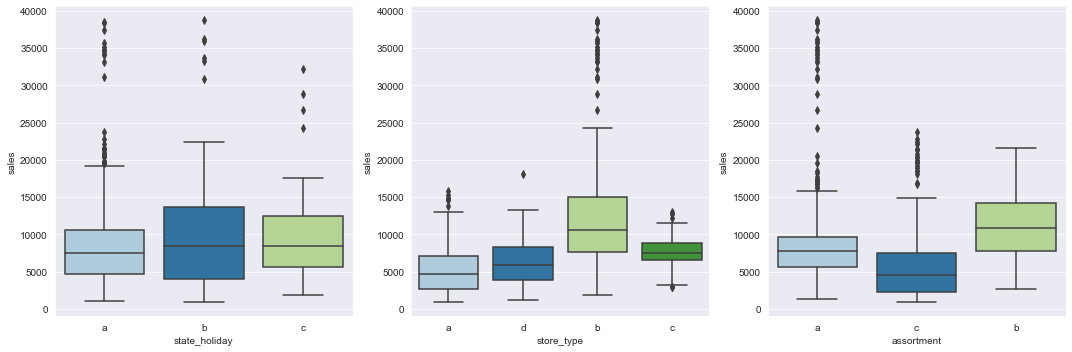

In [19]:
plt.figure( figsize=( 15, 5 ) )

aux = df1[( df1['state_holiday'] != '0' ) & ( df1['sales'] >0 ) ]

plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=aux )

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux )

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=aux )

plt.tight_layout()

# 2.0 Feature Engineering 

In [20]:
df2 = df1.copy()

## 2.1. Mind Map Hypotesis

Here it's shown a Mind Map of the agents that affect the phenomenon **"SALES"** to this problem. And based on this, I'll be created some hypotheses to be validated or not during the EDA.

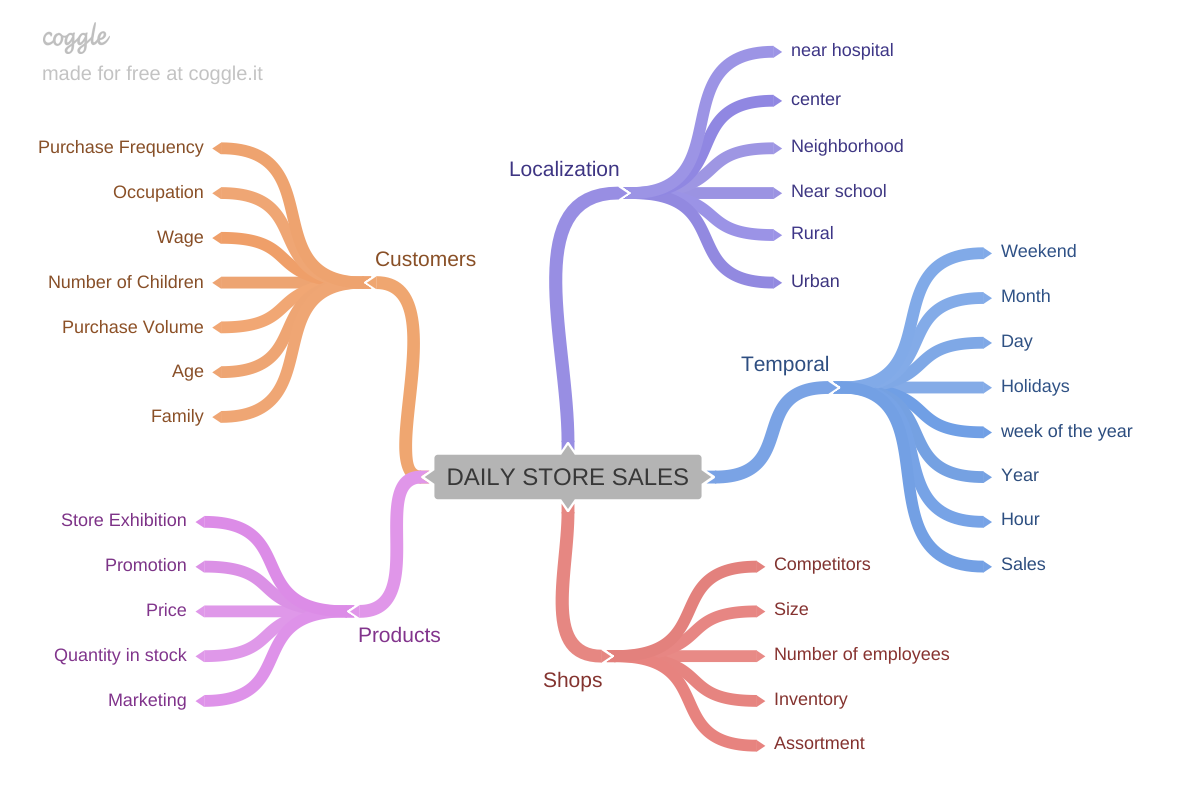

In [21]:
Image( 'img/DAILY_STORE_SALES_01.png' )

## 2.2. Creating Hypotheses

Creating Business Hypotheses that should be verified whether these Hypotheses are true or not. First I made a sub-list of some Hypotheses based on the agents "store", "product" and "time". After all, I propose a final Hypotheses list considering that a lot of hypotheses thought couldn't be answered because I have no information that makes me able to answer.

### 2.2.1 Store Hypotheses

**1.** Stores with more employees should sell more.

**2.** Stores with more inventory capacity should sell more.

**3.** Larger stores should sell more.

**4.** Stores with a larger assortment should sell more.

**5.** Stores with closer competitors should sell less

**6.** Stores with longer-term competitors should sell more.

### 2.2.2 Products Hypotheses

**1.** Stores that invest more in marketing should sell more

**2.** Stores with greater product exposure should sell more

**3.** Stores that have lower prices on products should sell more.

**4.** Stores with more aggressive promotions (bigger discounts) should sell more.

**5.** Stores with longer active promotions should sell more

**6.** Stores with more promotion days should sell more

**7.** Stores with more consecutive promotions should sell more

### 2.2.3 Time Hypotheses

**1.** Stores that open during the Christmas holiday should sell more

**2.** Stores should sell more over the years

**3.** Stores should sell more in the second half of the year

**4.** Stores should sell more after the 10th of each month

**5.** Stores should sell less on weekends

**6.** Stores should sell less during school holidays

## 2.3. Final Hypotheses List

**1.** Stores with a larger assortment should sell more.

**2.** Stores with closer competitors should sell less

**3.** Stores with longer-term competitors should sell more.

**4.** Stores with longer active promotions should sell more

**5.** Stores with more promotion days should sell more

**6.** Stores with more consecutive promotions should sell more

**7.** Stores open during the Christmas holiday should sell more

**8.** Stores should sell more over the years

**9.** Stores should sell more in the second half of the year

**10.** Stores should sell more after the 10th of each month

**11.** Stores should sell less on weekends

**12.** Stores should sell less during school holidays

## 2.4. Feature Engineering

Making new features from the column "date" such as:
 - year
 - month
 - day
 - week of year
 - year week
 
the column "competition_since" is the time the competition is opened as a date style. Where the year is pulled from 'competition_open_since_year' and the month is pulled from 'competition_open_since_month' and the "day" is started with 1 (the beginning of the month)

the column "promo_since" is the time since the promotion is activated

In [22]:
# year
df2['year']  = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day']   = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week.astype( np.int64 )

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] ) / 30 ).apply( lambda x: x.days ).astype( np.int64 )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-'+ df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - datetime.timedelta( days = 7) )

df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] ) / 7 ).apply( lambda x: x.days ).astype( np.int64 )

# assortment
df2['assortment']    = df2['assortment'].apply( lambda x: 'basic' if x=='a' else 'extra' if x=='b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x=='a' else 'easter_holiday' if x=='b' else 'christmas' if x=='c' else 'regular_day' )

In [23]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. Filtering Varibles

Filter some variables that make sense to the business problem.

In [24]:
df3 = df2.copy()

In [25]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1. Filtering Rows

Filtering the dataset taking out the sales values higher than zero because when this variable is zero, means that the store is closed. And then filtering by the column 'open'  different of zero, because just is interested when the store is open.

In [26]:
df3 = df3[( df3['open'] != 0 ) & ( df3['sales'] > 0 )]

## 3.2. Filtering Columns

Filtering some features that are not accessible at the predict moment or restricted by the own business.

- **"customers"**: I don't know how many customers will have in the weeks to come to be able to make a prediction

- **"open"**: It was filtered before, and then just matter predict when the drug store is open. And all of the rows here are 1 (open).

- **"promo_interval"** and **"month_map"**: Used just as auxiliary or for derivate another feature.

In [27]:
columns_drop = ['customers','open','promo_interval','month_map']
df3 = df3.drop( columns_drop, axis=1 )

df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0. EDA

In [28]:
df4 = df3.copy()

## 4.1. Univariate Analysis

### 4.1.1. Response Variable

It's possible to see how the sales price is distributed. The most concentration of the data is between 46 and 10000. Until 75% of the data is under 8360. This distribution seems like a normal distribution, with a light right asymmetry

In [28]:
df4['sales'].describe()

count    844338.000000
mean       6955.959134
std        3103.815515
min          46.000000
25%        4859.000000
50%        6369.000000
75%        8360.000000
max       41551.000000
Name: sales, dtype: float64

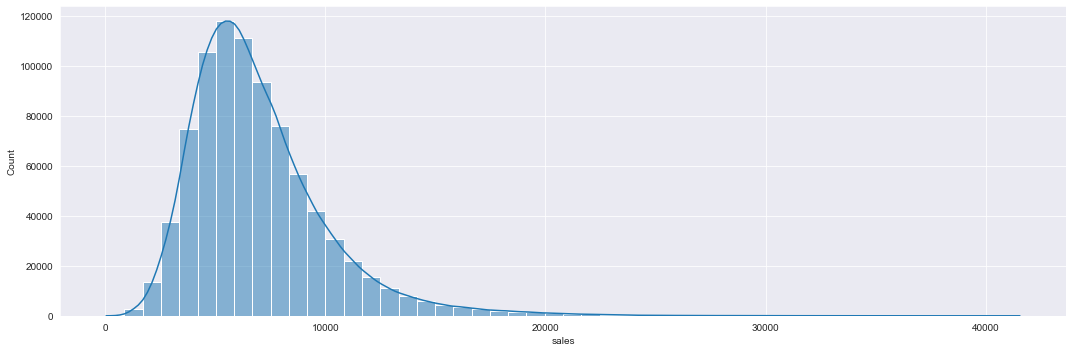

In [29]:
plt.figure( figsize=( 15, 5 ) )
sns.histplot( df4['sales'], kde=True, bins=50, color=sns.color_palette('Paired')[1] );

plt.tight_layout()

### 4.1.2. Numerical Variable

Some analysis that might be done 

**"promo2_since_year"**: It's possible to see the year when the stores started to participate in promotion2. And it's showed that this number goes up in 2013 relates to the years ago and after that goes down in 2014 and 2015 in a row.

**"customers"**: It is possible to see that the number of customers in general that frequent a store runs between 0 and 2000 per the date specified on the dataset. It's not useful for predicting because I have no information about how many customers there'll be in weeks to come. Shows up some information about the number of customers who frequent a drug store though

**"competition_open_since_year"**: As expected, it's normal that over the years the competition goes up.

**"is_promo"**: It's expected that there's more sales at the class 0 (no promotion), because there's much more day without promotion rather than with promotion.

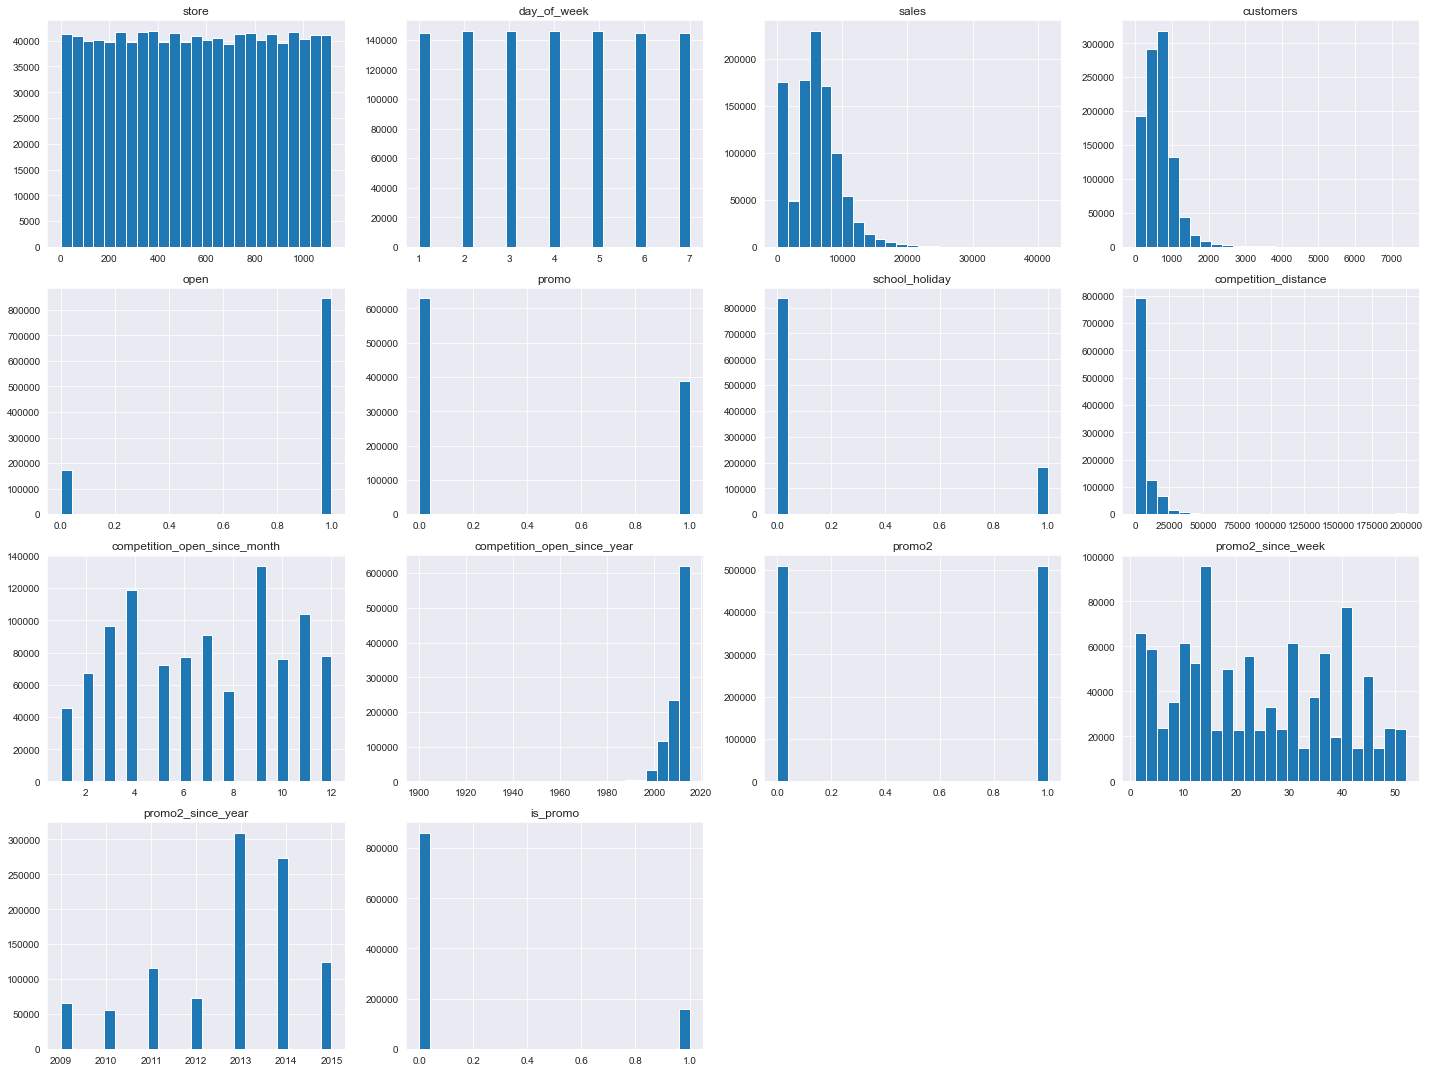

In [30]:
num_attributes.hist( bins =25, figsize=( 20, 15 ), color=sns.color_palette('Paired')[1] );

plt.tight_layout()

### 4.1.3. Categorical Variable

In [31]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


Filtering just the interested data

In [32]:
aux = df4[['state_holiday','store_type','assortment']]

for x in range( aux.shape[1] ):
    
    print( aux.iloc[:,x].name, '\n')
    print( aux.iloc[:,x].value_counts(), '\n' )

state_holiday 

regular_day       843428
public_holiday       694
easter_holiday       145
christmas             71
Name: state_holiday, dtype: int64 

store_type 

a    457042
d    258768
c    112968
b     15560
Name: store_type, dtype: int64 

assortment 

basic       444875
extended    391254
extra         8209
Name: assortment, dtype: int64 



**state_holiday**: In spite of being lower in an amount in the data set, the holiday "Christmas" has a peak higher than the easter holiday. In other words, it's more concentrated around a value. And then Christmas make sales more expensive than the easter holiday

**store_type**: The same as the state holiday, here the type 'd' is lower than 'a' but, 'd' is the store type that has the higher type of all in the sales analysis.

**assortment**: The difference between "extended" and "basic" is not so high in counts in the dataset neither in the sales analysis. But the "extra" has a much lower number of stores with this assortment, but your difference relates to the other ones is not so high, so it's worth analyzing what type of assortment pays off. 

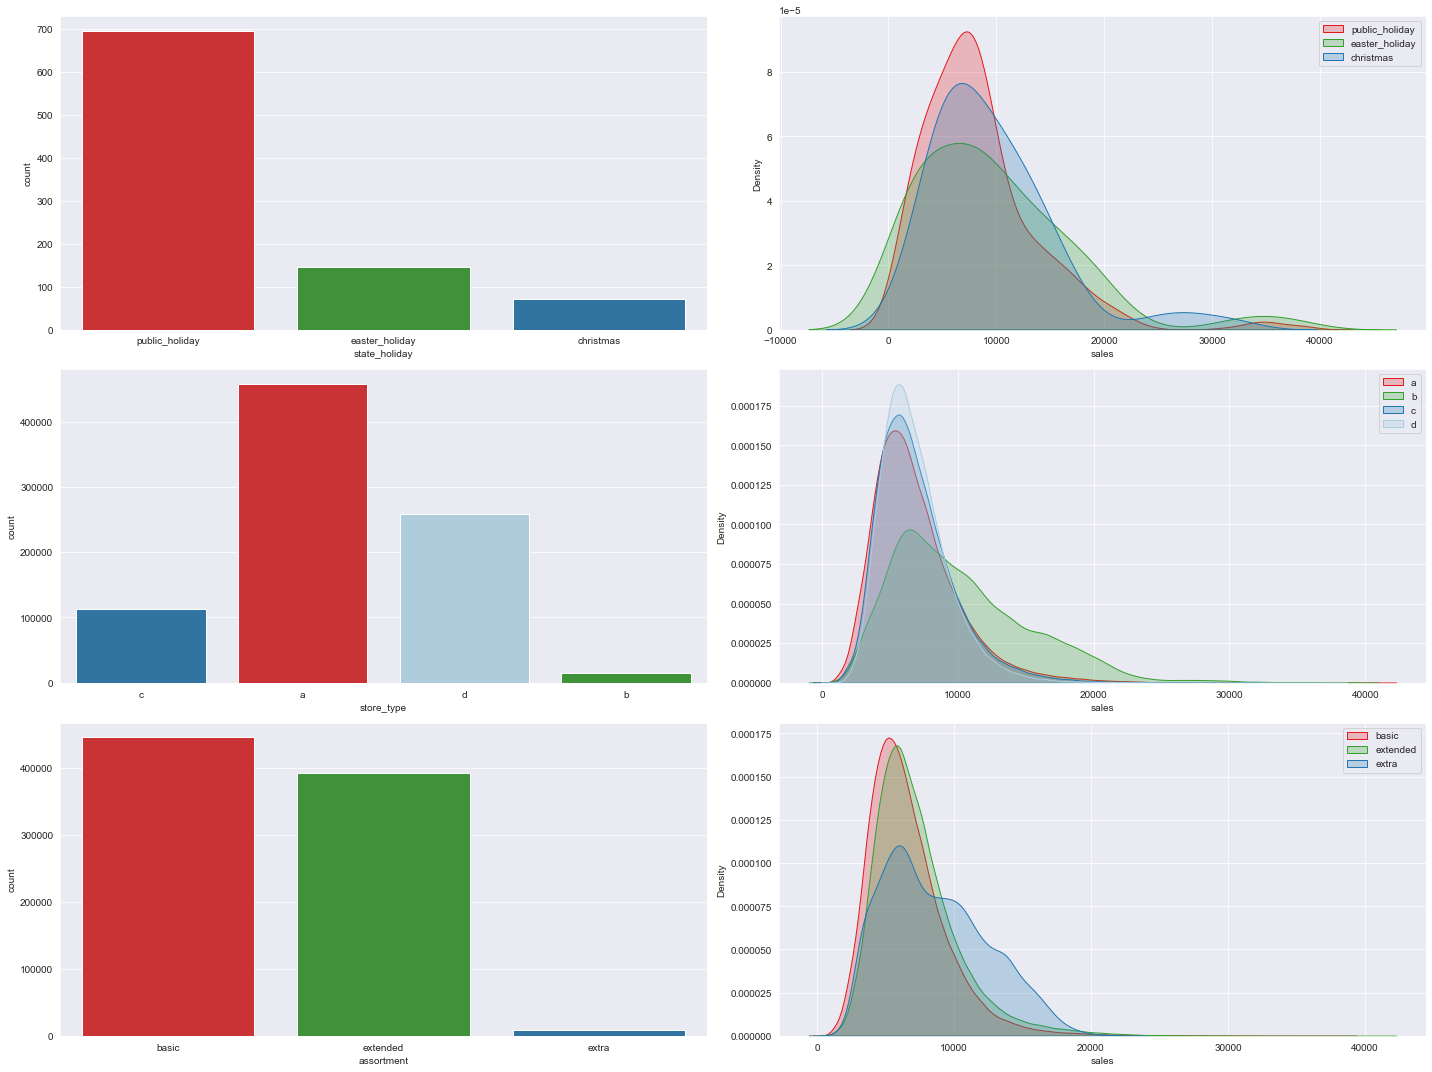

In [33]:
plt.figure( figsize=( 20, 15 ) )
#state_holiday

color = {'public_holiday': sns.color_palette('Paired')[5],
        'easter_holiday':  sns.color_palette('Paired')[3],
        'christmas':       sns.color_palette('Paired')[1]}

plt.subplot( 3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( data=a, x='state_holiday', palette=color )

plt.subplot( 3, 2, 2)
sns.kdeplot( df4[ df4['state_holiday'] == 'public_holiday']['sales'], shade=True, label='public_holiday', color=sns.color_palette('Paired')[5] )
sns.kdeplot( df4[ df4['state_holiday'] == 'easter_holiday']['sales'], shade=True, label='easter_holiday', color=sns.color_palette('Paired')[3] )
sns.kdeplot( df4[ df4['state_holiday'] == 'christmas']['sales'], shade=True, label='christmas', color=sns.color_palette('Paired')[1] )

plt.legend()

#store_type
color = {'a': sns.color_palette('Paired')[5],
        'b':  sns.color_palette('Paired')[3],
        'c':  sns.color_palette('Paired')[1],
        'd':  sns.color_palette('Paired')[0]}

plt.subplot( 3, 2, 3)
sns.countplot( data=df4, x='store_type', palette=color )

plt.subplot( 3, 2, 4)
sns.kdeplot( df4[ df4['store_type'] == 'a']['sales'], shade=True, label='a', color=sns.color_palette('Paired')[5] )
sns.kdeplot( df4[ df4['store_type'] == 'b']['sales'], shade=True, label='b', color=sns.color_palette('Paired')[3] )
sns.kdeplot( df4[ df4['store_type'] == 'c']['sales'], shade=True, label='c', color=sns.color_palette('Paired')[1] )
sns.kdeplot( df4[ df4['store_type'] == 'd']['sales'], shade=True, label='d', color=sns.color_palette('Paired')[0] )

plt.legend()

#assortment
color = {'basic': sns.color_palette('Paired')[5],
        'extended':  sns.color_palette('Paired')[3],
        'extra':       sns.color_palette('Paired')[1]}

plt.subplot( 3, 2, 5)
sns.countplot( data=df4, x='assortment', palette=color )

plt.subplot( 3, 2, 6)
sns.kdeplot( df4[ df4['assortment'] == 'basic']['sales'], shade=True, label='basic', color=sns.color_palette('Paired')[5] )
sns.kdeplot( df4[ df4['assortment'] == 'extended']['sales'], shade=True, label='extended', color=sns.color_palette('Paired')[3] )
sns.kdeplot( df4[ df4['assortment'] == 'extra']['sales'], shade=True, label='extra', color=sns.color_palette('Paired')[1] )

plt.legend()
plt.tight_layout()

## 4.2. Bivariate Analysis

### H1. Stores with a larger assortment should sell more.

This Hypothese is **FALSE**. Stores with a larger assortment sell **LESS**

<AxesSubplot:xlabel='year_week'>

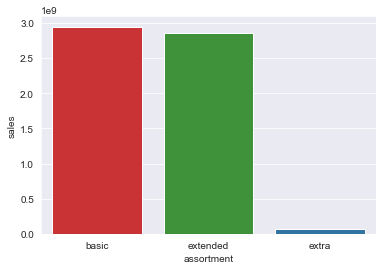

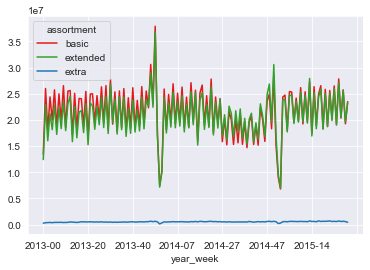

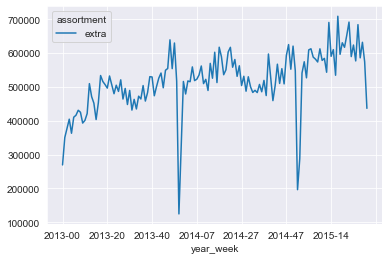

In [34]:
color = {'basic': sns.color_palette( 'Paired')[5], 
         'extended': sns.color_palette( 'Paired')[3], 
         'extra': sns.color_palette( 'Paired')[1]}

aux1 = df4[['assortment','sales']].groupby( 'assortment' ).sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1 , palette = color);

aux2 = df4[['assortment','year_week','sales']].groupby( ['year_week','assortment'] ).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot( color=color )

aux3 = aux2[aux2['assortment']=='extra']
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot( color=sns.color_palette( 'Paired')[1] )

### H2. Stores with closer competitors should sell less

This Hypothese is **FALSE**. Stores with a competition distance near has a sales price **HIGHER**

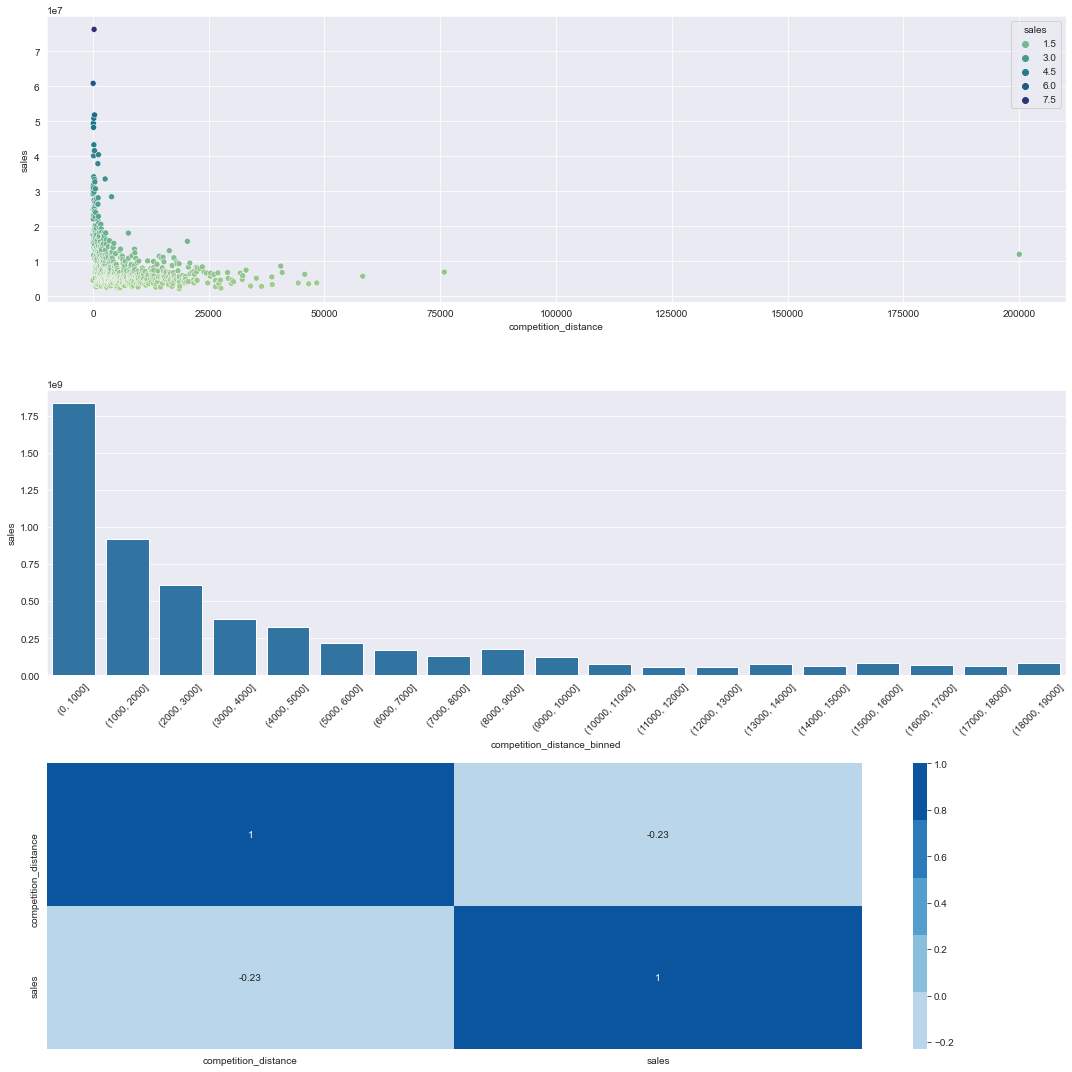

In [35]:
plt.figure( figsize=(15,15) )

# scatterplot
plt.subplot( 3, 1, 1)
aux1 = df4[['competition_distance','sales']].groupby( 'competition_distance' ).sum().reset_index()
sns.scatterplot( x='competition_distance', y='sales', data=aux1, hue ='sales', palette="crest" ) 

plt.tight_layout()

#barplot
plt.subplot( 3, 1, 2)
bins = list( np.arange( 0, 20000, 1000 ) )
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )

aux2 = aux1[['competition_distance_binned','sales']].groupby( 'competition_distance_binned' ).sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2, color=sns.color_palette('Paired')[1] );

plt.xticks(rotation=45);
plt.tight_layout()

# heatmap
plt.subplot( 3, 1, 3)
blues = sns.color_palette("Blues")[1:]
sns.heatmap( aux1.corr( method='pearson' ), annot=True, cmap=blues )

plt.tight_layout()

### H3. Stores with longer-term competitors should sell more.

**FALSE**. Stores with longer-term competition sell **LESS**. 
how much more near the competition is opened, higher is the sales price.

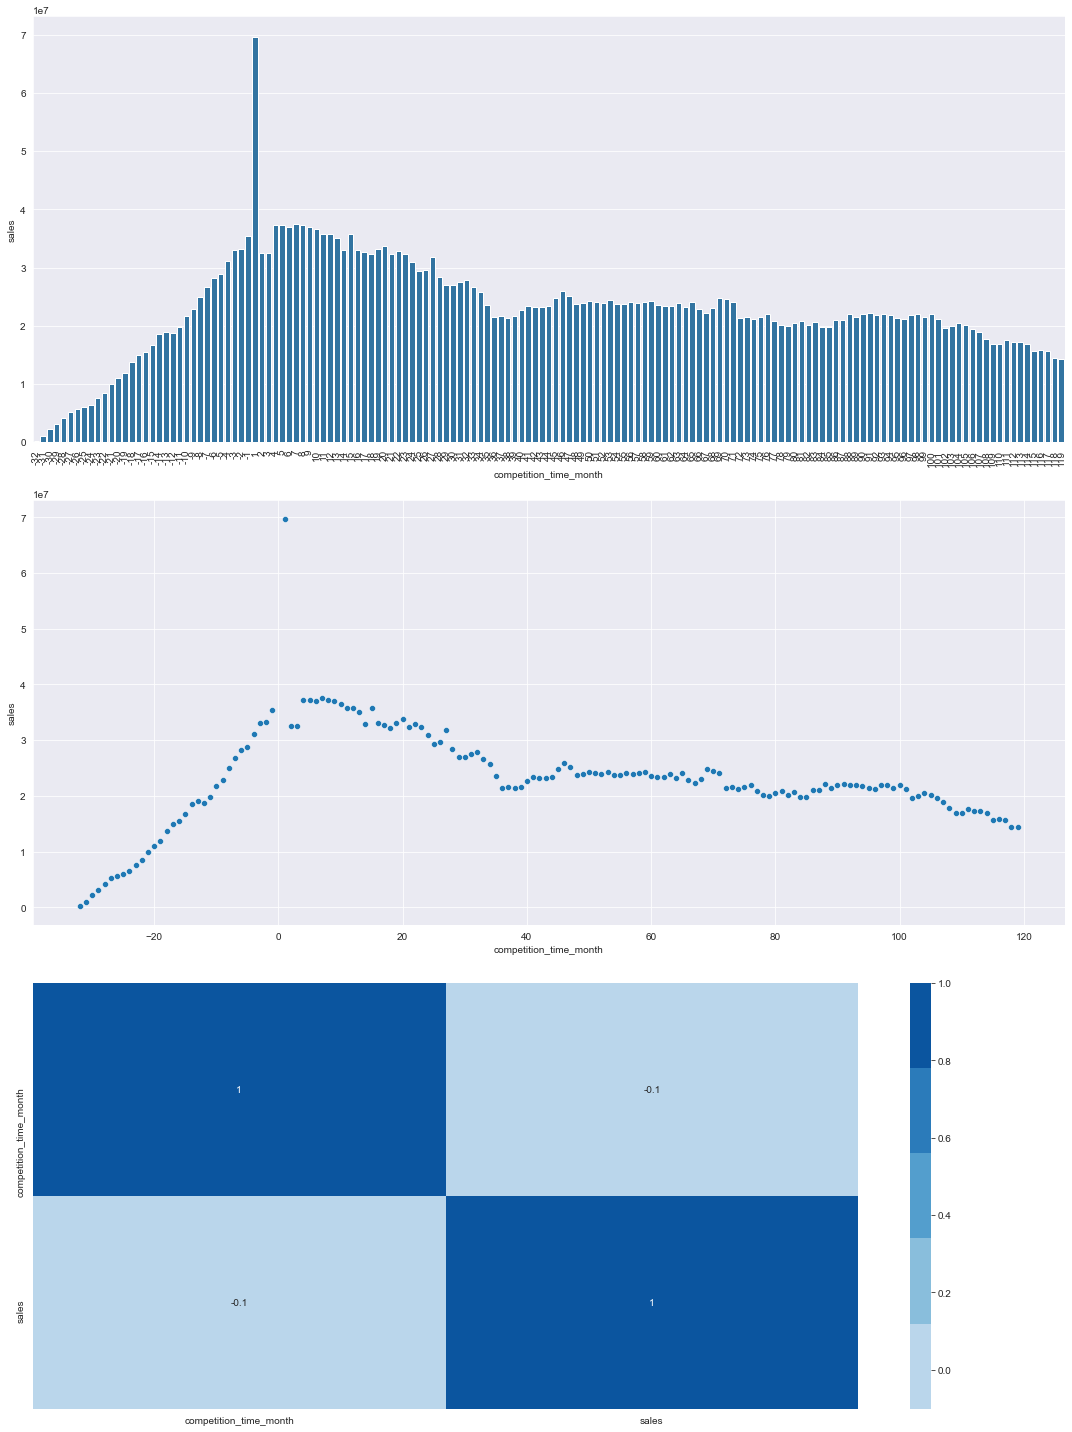

In [36]:
plt.figure( figsize=(15,20) )

aux1 = df4[['competition_time_month','sales']].groupby( 'competition_time_month' ).sum().reset_index()

plt.subplot( 3, 1, 1)
# filter to facilitate the understanding of the data
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month'] != 0 )]
sns.barplot( x='competition_time_month', y='sales', data=aux2, color=sns.color_palette('Paired')[1] );
plt.xticks(rotation=90);
plt.tight_layout()

plt.subplot( 3, 1, 2)
sns.scatterplot( x='competition_time_month', y='sales', data=aux2, color=sns.color_palette('Paired')[1] );
plt.tight_layout()

plt.subplot( 3, 1, 3)
sns.heatmap( aux1.corr( method='pearson' ), annot=True, cmap=blues )
plt.tight_layout()

### H4. Stores with longer active promotions should sell more

**FALSE**. Stores with activated promotions for more time, sell **LESS**

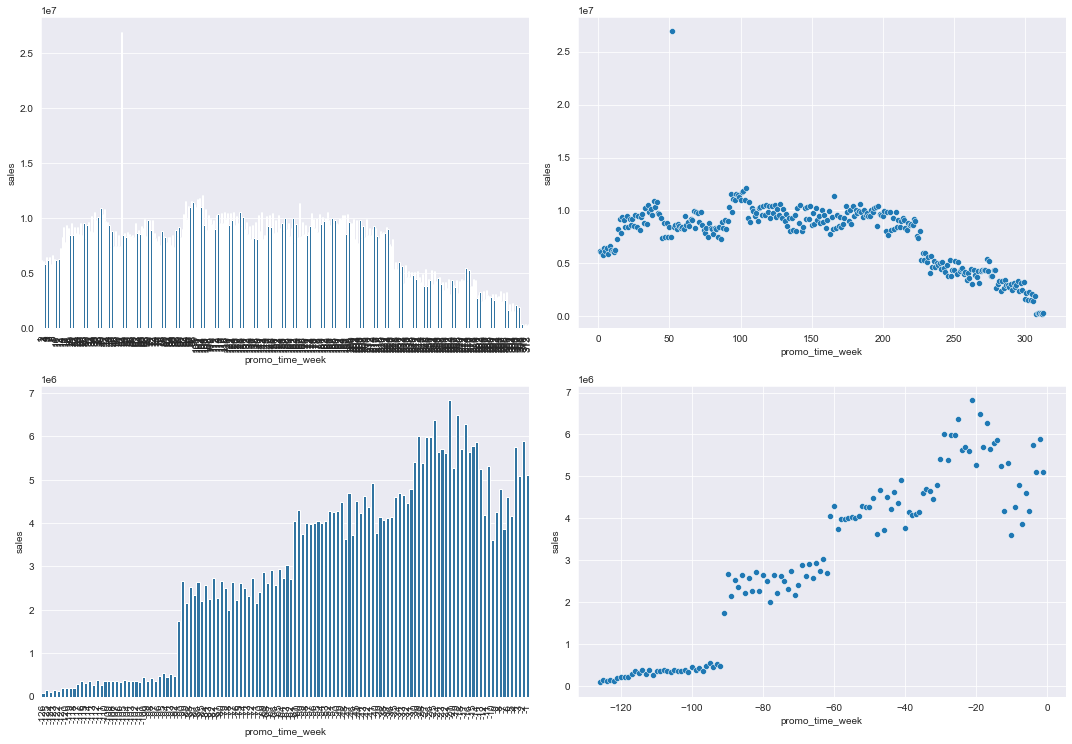

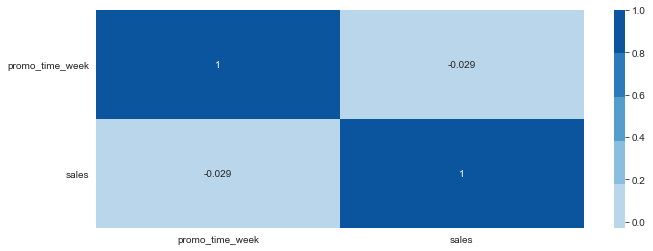

In [37]:
plt.figure( figsize=(15,15) )

aux1 = df4[['sales','promo_time_week']].groupby( 'promo_time_week' ).sum().reset_index()

grid = GridSpec( 3, 2 )

plt.subplot( grid[0,0] )
aux2 = aux1[aux1['promo_time_week'] > 0 ] # promo extended
sns.barplot( x='promo_time_week', y='sales', data=aux2, color=sns.color_palette('Paired')[1]);
plt.xticks( rotation = 90 );
plt.tight_layout()

plt.subplot( grid[0,1] )
sns.scatterplot( x='promo_time_week', y='sales', data=aux2, color=sns.color_palette('Paired')[1] );
plt.tight_layout()

plt.subplot( grid[1,0] )
aux3 = aux1[aux1['promo_time_week'] < 0 ] # regular promo
sns.barplot( x='promo_time_week', y='sales', data=aux3, color=sns.color_palette('Paired')[1] );
plt.xticks( rotation = 90 );
plt.tight_layout()

plt.subplot( grid[1,1] )
sns.scatterplot( x='promo_time_week', y='sales', data=aux3, color=sns.color_palette('Paired')[1] );
plt.tight_layout()

plt.figure( figsize=( 10, 10 ) )
plt.subplot( grid[2,:] )
sns.heatmap( aux1.corr( method='pearson' ), annot=True, cmap=blues )
plt.tight_layout()

### <S>H5. Stores with more promotion days should sell more</s>

The same idea as the **H4**, Stores with longer active promotions means that have more promotion days too.

### H6. Stores with more consecutive promotions should sell more

**FALSE**. Store with consecutive promotions sell **LESS**

In [38]:
df4[['promo','sales','promo2']].groupby( ['promo','promo2'] ).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


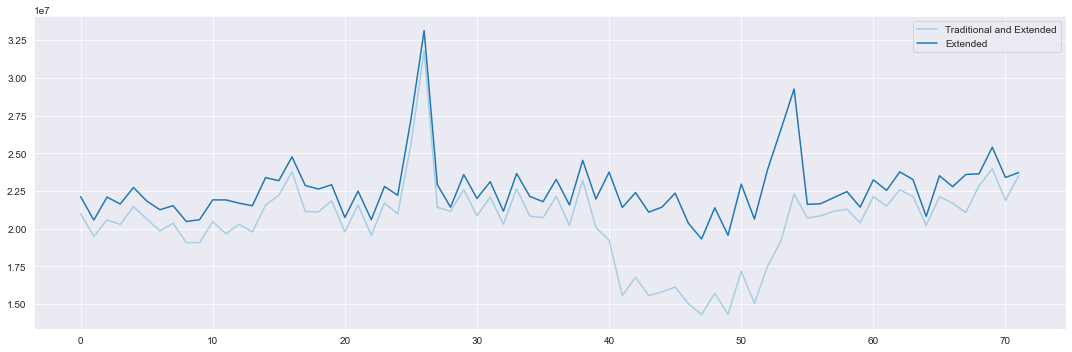

In [39]:
aux1 = df4[( df4['promo'] == 1 ) &  ( df4['promo2'] == 1 )][['year_week','sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot( figsize=(15,5) )

aux2 = df4[( df4['promo'] == 1 ) &  ( df4['promo2'] == 0 )][['year_week','sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax=ax )

ax.legend( labels=['Traditional and Extended', 'Extended'] )
plt.tight_layout()

### H7. Stores open during the Christmas holiday should sell more

**FALSE**. Stores that is open during the Christmas holiday sell **LESS** on the whole and along the years as well.

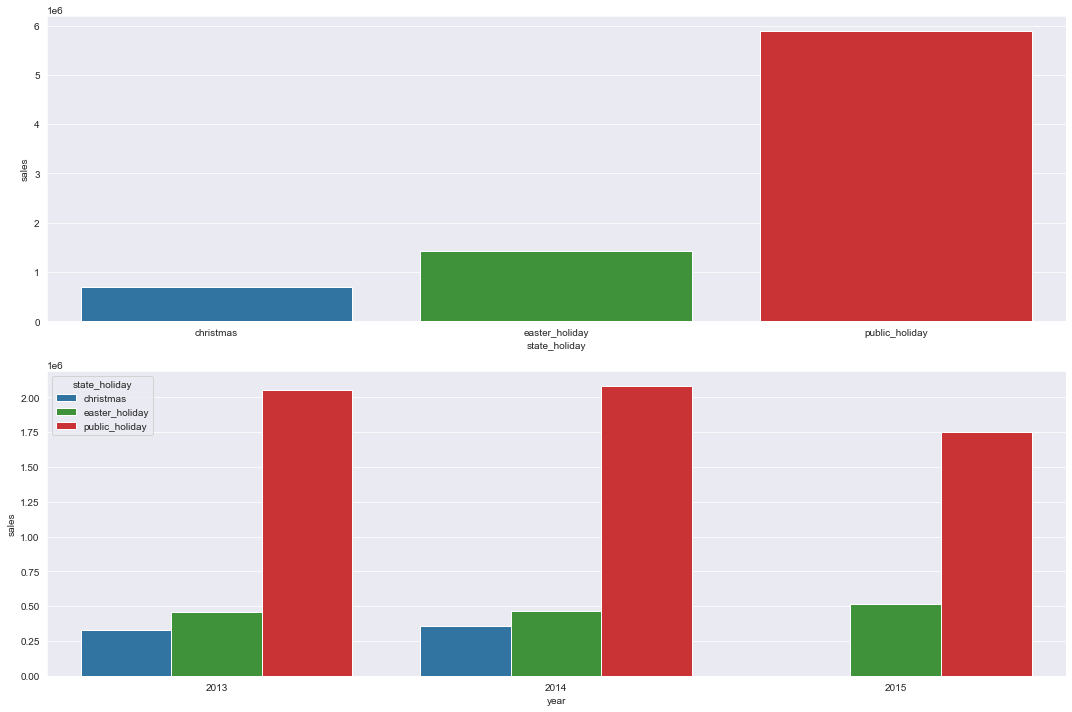

In [40]:
plt.figure( figsize=(15,10) )
aux = df4[ df4['state_holiday'] != 'regular_day']

color2 = {'public_holiday': sns.color_palette( 'Paired')[5], 
         'easter_holiday': sns.color_palette( 'Paired')[3], 
         'christmas': sns.color_palette( 'Paired')[1]}

plt.subplot( 2, 1, 1 )
aux1 = aux[['state_holiday','sales']].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 , palette=color2 )
plt.tight_layout()

plt.subplot( 2, 1, 2 )
aux2 = aux[['state_holiday','sales','year']].groupby( ['year','state_holiday'] ).sum().reset_index()
sns.barplot( x='year', y='sales', data=aux2, hue='state_holiday', palette=color2 )
plt.tight_layout()

### H8. Stores should sell more over the years

**FALSE**. Along the years the stores sell **LESS**. 

obs: 2015 is not complet in the dataset.

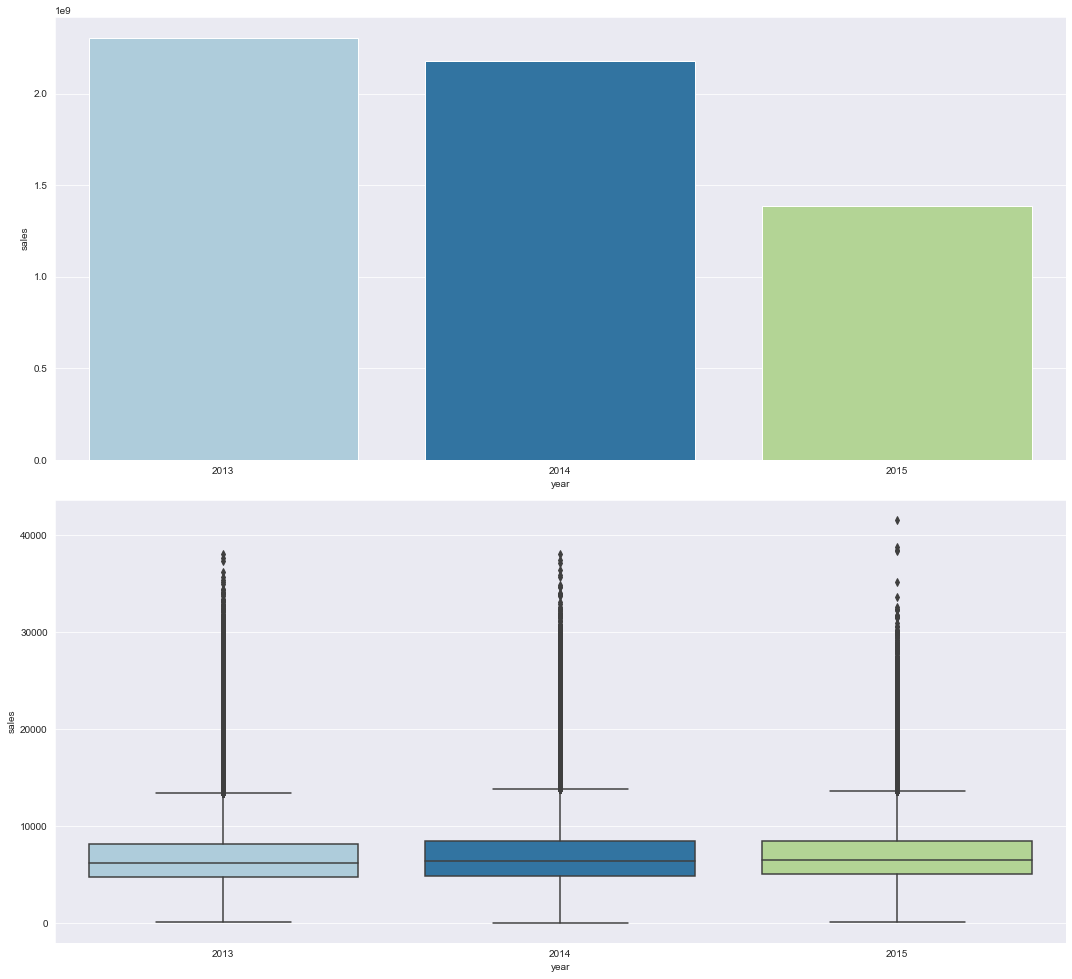

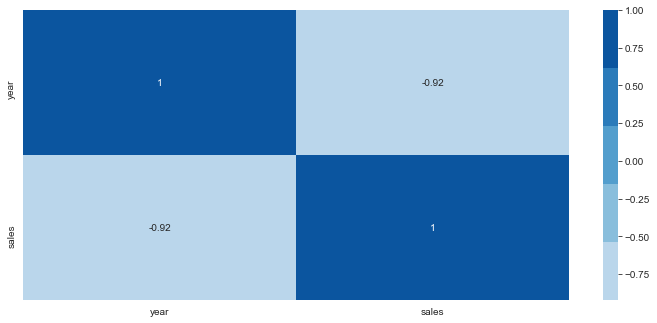

In [41]:
plt.figure( figsize=(15,20) )

aux = df4[['year','sales']].groupby( 'year' ).sum().reset_index()

plt.subplot( 3, 1, 1 )
sns.barplot( x='year', y='sales', data=aux );
plt.tight_layout()

plt.subplot( 3, 1, 2 )
sns.boxplot( x='year', y='sales', data=df4 );
plt.tight_layout()

plt.figure( figsize=( 10, 13 ) )
plt.subplot( 3, 1, 3 )
sns.heatmap( aux.corr( method='pearson'), annot=True, cmap=blues )
plt.tight_layout()

### H9. Stores should sell more in the second half of the year

**FALSE**. Stores sell **LESS** in the second half of the year.

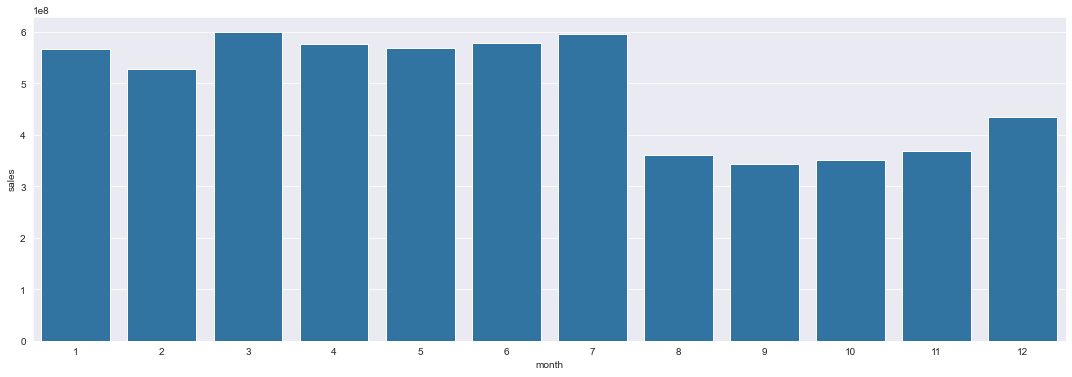

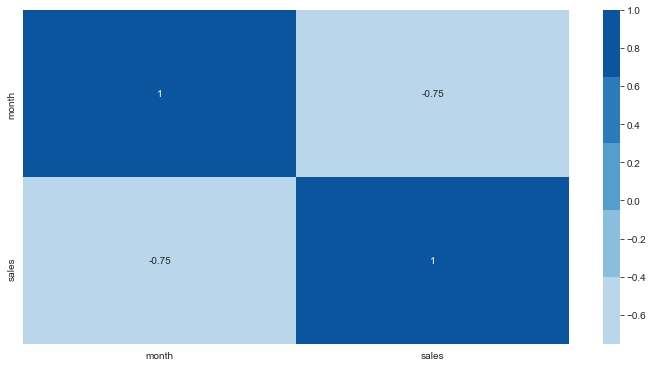

In [42]:
plt.figure( figsize=(15,10) )

aux = df4[['month','sales']].groupby( 'month' ).sum().reset_index()

plt.subplot( 2, 1, 1 )
sns.barplot( x='month', y='sales', data=aux, color=sns.color_palette('Paired')[1] );
plt.tight_layout()

plt.figure( figsize=( 10, 10 ) )
plt.subplot( 2, 1, 2 )
sns.heatmap( aux.corr( method='pearson'), annot=True, cmap=blues )
plt.tight_layout()

### H10. Stores should sell more after the 10th of each month

**TRUE**

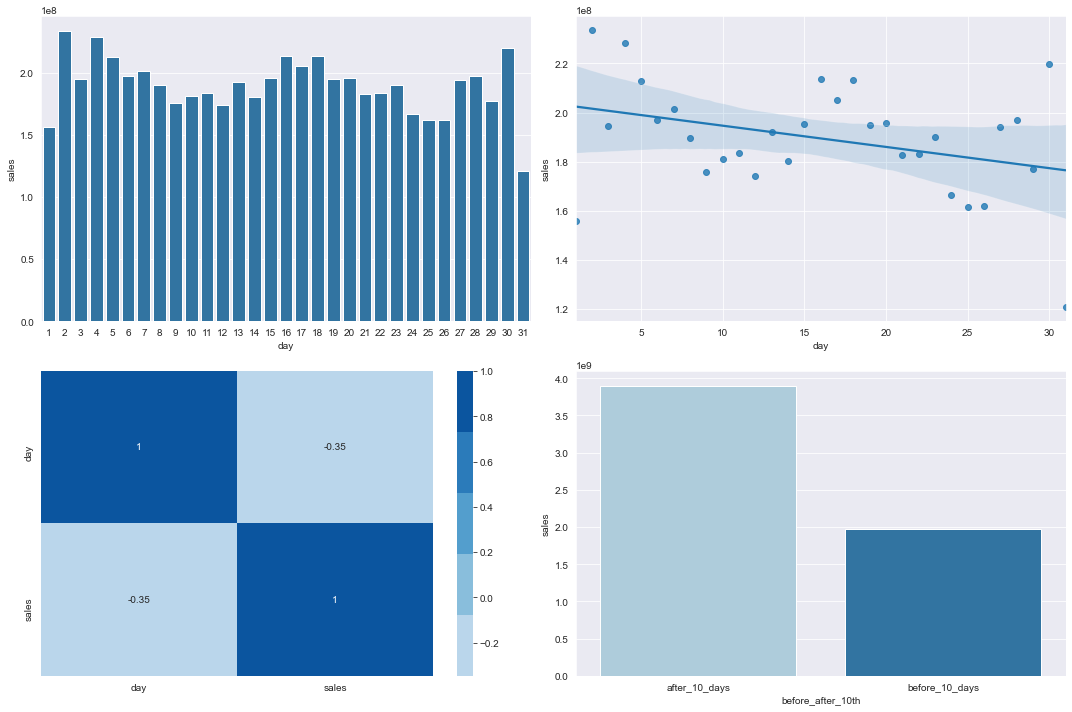

In [43]:
plt.figure( figsize=(15,10) )

aux = df4[['day','sales']].groupby( 'day' ).sum().reset_index()

plt.subplot( 2, 2, 1 )
sns.barplot( x='day', y='sales', data=aux, color=sns.color_palette('Paired')[1] );
plt.tight_layout()

plt.subplot( 2, 2, 2 )
sns.regplot( x='day', y='sales', data=aux, color=sns.color_palette('Paired')[1] );
plt.tight_layout()

plt.subplot( 2, 2, 3 )
sns.heatmap( aux.corr( method='pearson'), annot=True, cmap=blues )
plt.tight_layout()

plt.subplot( 2, 2, 4 )
aux['before_after_10th'] = aux['day'].apply( lambda x: 'before_10_days' if x<=10 else 'after_10_days' )

aux1 = aux[['before_after_10th','sales']].groupby( 'before_after_10th' ).sum().reset_index()
sns.barplot( x='before_after_10th', y='sales', data=aux1 );
plt.tight_layout()

### H11. Stores should sell less on weekends

**TRUE**

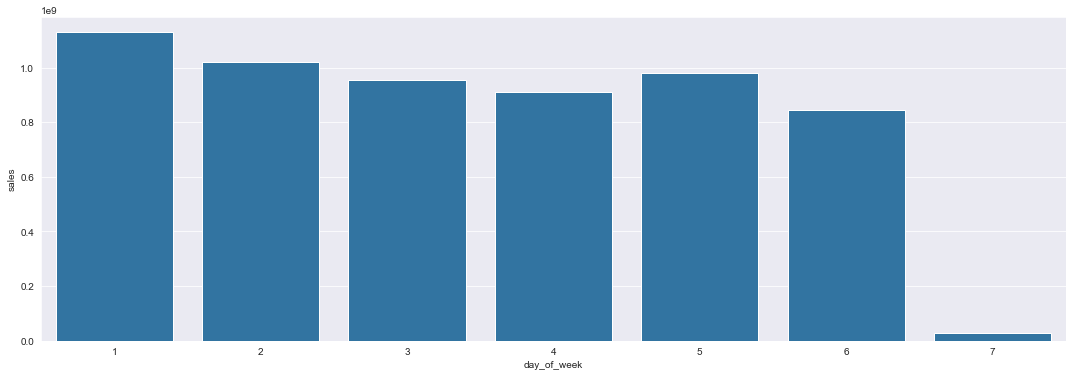

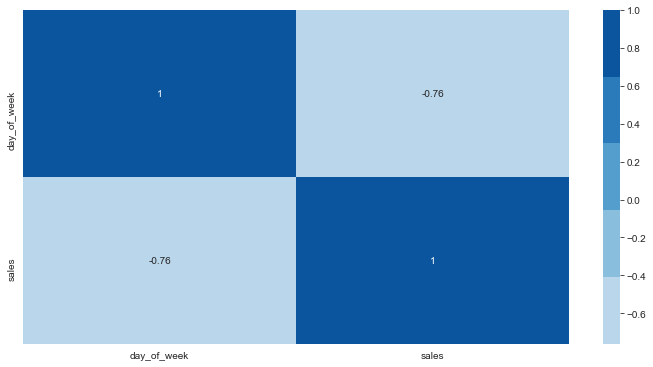

In [44]:
aux = df4[['day_of_week','sales']].groupby( 'day_of_week' ).sum().reset_index()

plt.figure( figsize=( 15, 10 ) )
plt.subplot( 2, 1, 1 )
sns.barplot( x='day_of_week', y='sales', data=aux,  color=sns.color_palette('Paired')[1] );
plt.tight_layout()

plt.figure( figsize=( 10, 10 ) )
plt.subplot( 2, 1, 2 )
sns.heatmap( aux.corr( method='pearson'), annot=True, cmap=blues )
plt.tight_layout()

### H12. Stores should sell less during school holidays
**TRUE**. On the whole, the stores sell less during the school holidays but in August it's not true.  That's might expected because it's kind of the moment of vocations

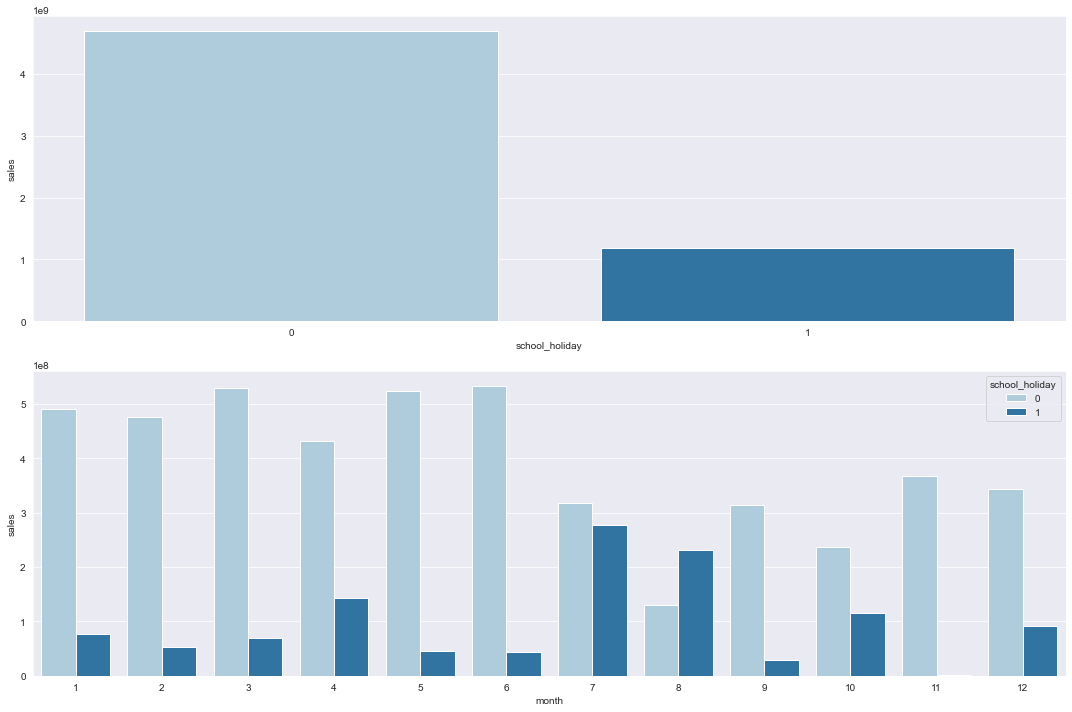

In [45]:
plt.figure( figsize=(15,10) )

plt.subplot( 2, 1, 1 )
aux = df4[['school_holiday','sales']].groupby( 'school_holiday' ).sum().reset_index()
sns.barplot( x='school_holiday', y='sales', data=aux ); 
plt.tight_layout()

plt.subplot( 2, 1, 2 )
aux1 = df4[['month','school_holiday','sales']].groupby( ['month','school_holiday'] ).sum().reset_index()
sns.barplot( x='month', y='sales', data=aux1, hue='school_holiday' );
plt.tight_layout()

## 4.3. Multivariate Analysis

### 4.3.1 Numerical Attributes

Using the corelation of Pearson to analyze the linear relationship between each variable.

<AxesSubplot:>

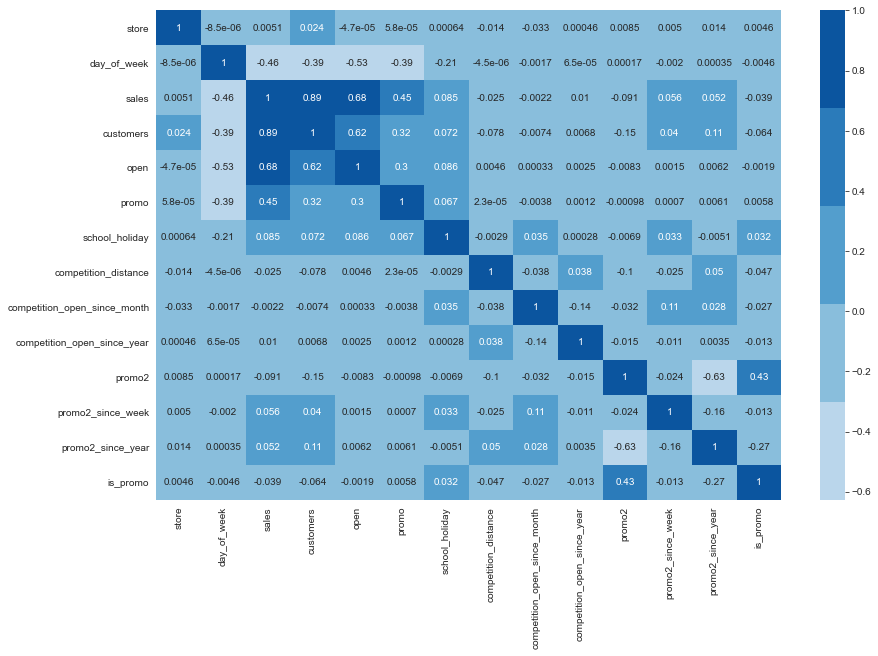

In [46]:
plt.figure( figsize=(14,9) )

corr = num_attributes.corr( method='pearson' )
sns.heatmap( corr, annot=True, cmap=blues )

### 4.3.1 Categorical Attributes

In [29]:
cat = df4.select_dtypes( include='object' )
cat = cat.drop( 'year_week', axis=1 )
cat.head()

,state_holiday,store_type,assortment
0,regular_day,c,basic
1,regular_day,a,basic
2,regular_day,a,basic
3,regular_day,c,extended
4,regular_day,a,basic


> In statistics, Cramér's V (sometimes referred to as Cramér's phi and denoted as φc) is a measure of association between two nominal variables, giving a value between 0 and +1 (inclusive). It is based on Pearson's chi-squared statistic and was published by Harald Cramér in 1946. (Wikipedia)

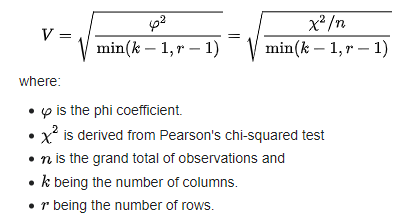

> Cramér's V can be a heavily biased estimator of its population counterpart and will tend to overestimate the strength of association. A bias correction, using the above notation, is given by (Wikipedia)

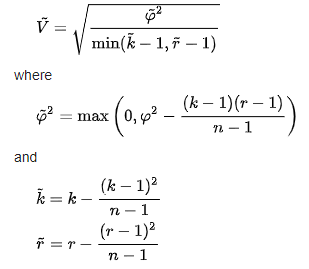

<AxesSubplot:>

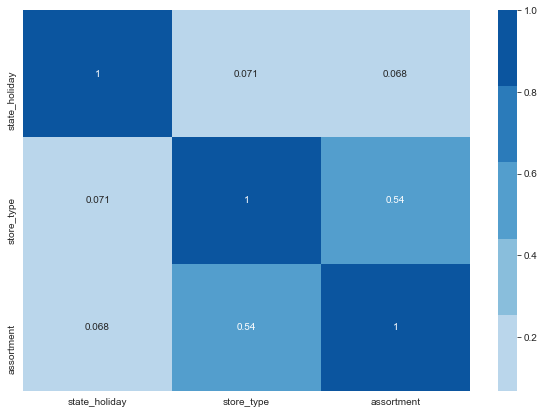

In [48]:
plt.figure( figsize=(10,7) )

# Calculate Cramer V
a1 = cramer_v( cat['state_holiday'], cat['state_holiday'] )
a2 = cramer_v( cat['state_holiday'], cat['store_type'] )
a3 = cramer_v( cat['state_holiday'], cat['assortment'] )

a4 = cramer_v( cat['store_type'], cat['state_holiday'] )
a5 = cramer_v( cat['store_type'], cat['store_type'] )
a6 = cramer_v( cat['store_type'], cat['assortment'] )

a7 = cramer_v( cat['assortment'], cat['state_holiday'] )
a8 = cramer_v( cat['assortment'], cat['store_type'] )
a9 = cramer_v( cat['assortment'], cat['assortment'] )

# Final Dataset
aux = pd.DataFrame( {'state_holiday': [a1,a2,a3],
               'store_type': [a4,a5,a6],
               'assortment': [a7,a8,a9]
              })
aux = aux.set_index( aux.columns )
sns.heatmap( aux, annot=True, cmap=blues )

# 5.0. Data Preparation

Numeric Variables
> The two most discussed scaling methods are Normalization and Standardization. Normalization typically means rescales the values into a range of [0,1]. Standardization typically means rescales data to have a mean of 0 and a standard deviation of 1 (unit variance). (https://towardsdatascience.com/normalization-vs-standardization-quantitative-analysis-a91e8a79cebf)

Categoric Variables

The purpose of the Data Preparation stage is to get the data into the best format for machine learning. I've already done two other steps of data preparation which was: 

 1. Data Cleaning
 2. Feature Engineering
 
Now, I'm doing transformations to make sure that the data will be understood better by the machine learning algorithm.

In [29]:
df5 = df4.copy()

In [30]:
df5.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

## 5.1. <s>Standardization</s>

There isn't any variable that behavior as a Normal Distribution.

## 5.2. Rescaling

 - The MinMax is helpful when the feature has a non-Normal distribution and is not so influenced by the outliers

 - The RobustScaler is helpful when the feature has a Normal distribution or not, and is much influenced by the outliers

In [30]:
# select the features that are numeric
aux = df5.select_dtypes( include=['int64','float64'] )
aux.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,31,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,31,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,31,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,31,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,31,4,0


Taking a look at the behavior of each variable. 

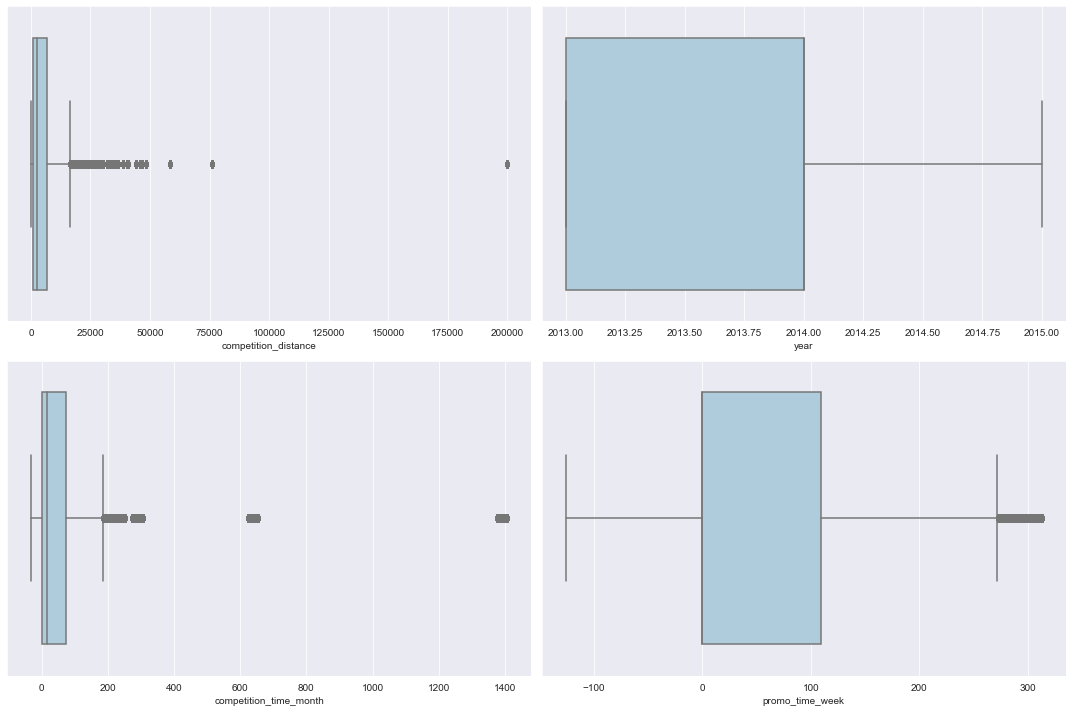

In [31]:
plt.figure( figsize=(15,10) )

plt.subplot( 2, 2, 1 )
sns.boxplot( data=df5, x='competition_distance' );
plt.tight_layout()

plt.subplot( 2, 2, 2 )
sns.boxplot( data=df5, x='year' );
plt.tight_layout()

plt.subplot( 2, 2, 3 )
sns.boxplot( data=df5, x='competition_time_month' );
plt.tight_layout()

plt.subplot( 2, 2, 4 )
sns.boxplot( data=df5, x='promo_time_week' );
plt.tight_layout()

I'm going to use the MinMaxScaler and RobustScaler to Rescaling the variables.

   - **MinMaxScaler**:  Using variables that have not been much influenced by outliers. Because in its equation take into account the MAX and MIN value.

   - **RobustScaler**: Using the variables that have a higher influence from outliers. Instead of taking into account the MIN and MAX values, this method considers the first and third quartiles to Rescaling the variable.



To The features "competition_distance" and "competition_time_month" will be applied to the RobustScaler Method. Because It's a variable much affect by the outliers as seen over here on the boxplot.

And the variables "year" and "promo_time_week" will be applied to the MinMax because it's not much affected by the outliers.

In [32]:
rs  = RobustScaler()
mms = MinMaxScaler()

# competition dsitance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
pickle.dump( rs, open('parameters/competition_distance_scaler.plk', 'wb' ) )

# competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )
pickle.dump( rs, open('parameters/competition_time_month_scaler.plk', 'wb' ) )

# year
df5['year'] = mms.fit_transform( df5[['year']].values )
pickle.dump( mms, open('parameters/year_scaler.plk', 'wb' ) )

# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )
pickle.dump( mms, open('parameters/promo_time_week_scaler.plk', 'wb' ) )

## 5.3. Transformation

### 5.3.1 Encoding

> In ML models we are often required to convert the categorical i.e text features to its numeric representation. The two most common ways to do this is to use Label Encoder or OneHot Encoder. However, most of the ML newbies are not familiar with the impact of the choice of encoding has on their model, the accuracy of the model may shift by large numbers by using the right encoding at the right scenario. (https://towardsdatascience.com/choosing-the-right-encoding-method-label-vs-onehot-encoder-a4434493149b)

For the first step of the CRISP-DS method, I've decided to apply these three different ENCODERS based on the feature characters.

**Label Encoding**:
encode labels with a value between 0 and n_classes-1 where n is the number of distinct labels. If a label repeats it assigns the same value to as assigned earlier.

**One Hot Encoding**:
What one hot encoding does is, it takes a column which has categorical data, which has been label encoded and then splits the column into multiple columns. The numbers are replaced by 1s and 0s, depending on which column has what value.

**Ordinal Enconding**:
It's basically the same as the Label Encoding, increased with the information about the "order" because in the Ordinal Encoding the "Order" makes difference. For instance, in this case, 3 is higher than 2, and 2 is higher than 1. And this information is important.

In [33]:
# state_holiday - One Hot encoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )
pickle.dump( le, open( 'parameters/store_type_scaler.pkl', 'wb' ) )

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

### 5.3.2 . Response Variable Transformation

Applied the log Transformation to make the response variable closer to a normal distribution.

In [34]:
df5['sales'] = np.log1p( df5['sales'] )

### 5.3.2. Nature Tranformation

The variable that has an idea of a cycle, loses its importance (in parts) when It's known that from January to December takes 12 months, but the distance from December 2020 to January 2021 is just one month. When the feature is like in this example. I lost the cyclical behavior that this data has. with this approach, the dataset dimensionality is going to go up, but pass to considering the cyclical nature of the variables and then, provide more information about the phenomenon

In [35]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# day 
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

# 6.0. Feature Selection

> “the simplest solution is almost always the best.” (Occam’s Razor)

The level of solution is totaly dependent of the number of features in the dataset. It's the importance of the feature selection, In order to reduce the complexity of the dataset it's required reduce the number of features.

In [32]:
df6 = df5.copy()


## 6.1. Split DataFrame into Training and Test

In [33]:
# dropping some variables because other ones were derived from them.
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week' ]
df6 = df6.drop( cols_drop, axis=1 )

As it's a problem that involves the time, it's not possible just split the data in training and test like in the TrainTestSplit from sklearn. 

In [34]:
# the most recent date
df6[['store','date']].groupby( 'store' ).max().reset_index()['date'][0]

Timestamp('2015-07-31 00:00:00')

In [35]:
# farther date
df6[['store','date']].groupby( 'store' ).min().reset_index()['date'][0]

Timestamp('2013-01-02 00:00:00')

Here, I'm going to subtract six weeks (because is the time that is proposed to be predicted) from the most recent date, and each value before this date will be the training data, meanwhile, the data after this date will be the test data.

In [38]:
df6[['store','date']].groupby( 'store' ).max().reset_index()['date'][0] - datetime.timedelta( days=6*7 )

Timestamp('2015-06-19 00:00:00')

In [39]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )

print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.1. Boruta as Feature Selection

As known that this process might take a long time, I ended up running this just once and added the results in another variable.

In [40]:
# # Traininh and test dataset for boruta
# X_train_n = X_train.drop( ['date','sales'], axis=1 ).values
# y_train_n = y_train.values.ravel()

# #Define Random Forest
# rf = RandomForestRegressor( n_jobs=-1 )

# # Define Boruta
# boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, y_train_n )

### 6.2.1 Best Features from Boruta

In [62]:
# cols_selected = boruta.support_.tolist()

# # best feature
# X_train_fs = X_train.drop( ['date','sales'], axis=1 )
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.tolist()

# cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

### 6.3. Manuel Feature Selection

Added the features week_of_year_sin and month_sin

In [40]:
# features select by boruta
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

# final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7.0. Machine Learning

It'll be run a baseline model to be compared, linear models to have sight about whether this problem runs as a linear problem and non-linear models.

In [41]:
x_train = X_train[ cols_selected_boruta ]
# y_train = X_train['sales'] - already defined before

x_test  = X_test[ cols_selected_boruta ]
# y_test = X_test['sales'] - already defined before

# time series data preparation to crossvalidation
x_training = X_train[ cols_selected_boruta_full ]

## 7.1. Average Model

It's the most simple model to predict the event "sales". where it'll be sold by the average price of each drug store. And then to compare another model is needed to have at least a baseline model to be compared.

In [39]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename( columns={'sales': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1( yhat_baseline ) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2. Linear Regression Model

Linear regression, or ordinary least squares (OLS), is the simplest and most classic linear
method for regression. Linear regression finds the parameters w and b that minimize
the mean squared error between predictions and the true regression targets, y,
on the training set. The mean squared error is the sum of the squared differences
between the predictions and the true values, divided by the number of samples. Linear
regression has no parameters, which is a benefit, but it also has no way to control
model complexity.

In [97]:
# model
lr = LinearRegression().fit( x_train, y_train )

# prediction
yhat_lr = lr.predict( x_test )

# performance
lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1( yhat_lr ) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 7.2.1 Linear Regression Model Cross Validation

In [98]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', LinearRegression(), verbose=False )
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3. Linear Regression Regularizaded Model

Lasso (Least Absolute Shrinkage and Selection Operator) It is a statistical formula for the regularisation of data models and feature selection. 

> Regularization is an important concept that is used to avoid overfitting of the data, especially when the trained and test data are much varying. Regularization is implemented by adding a “penalty” term to the best fit derived from the trained data, to achieve a lesser variance with the tested data and also restricts the influence of predictor variables over the output variable by compressing their coefficients. (https://www.mygreatlearning.com/blog/understanding-of-lasso-regression/)

> Lasso regression is a regularization technique. It is used over regression methods for a more accurate prediction. This model uses shrinkage. Shrinkage is where data values are shrunk towards a central point as the mean. The lasso procedure encourages simple, sparse models (i.e. models with fewer parameters). (https://www.mygreatlearning.com/blog/understanding-of-lasso-regression/)

In [99]:
# model
lrr = Lasso( alpha=0.01 ).fit( x_train, y_train )

# prediction
yhat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.3.1 Linear Regression Regularizaded Model Cross Validation

In [100]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', Lasso( alpha=0.01 ), verbose=False )
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 7.4. Random Forest Regressor

A random forest is a machine learning technique that’s used to solve regression and classification problems. It utilizes ensemble learning, which is a technique that combines many classifiers to provide solutions to complex problems.

> A random forest algorithm consists of many decision trees. The ‘forest’ generated by the random forest algorithm is trained through bagging or bootstrap aggregating. Bagging is an ensemble meta-algorithm that improves the accuracy of machine learning algorithms. The (random forest) algorithm establishes the outcome based on the predictions of the decision trees. It predicts by taking the average or mean of the output from various trees. Increasing the number of trees increases the precision of the outcome. (https://www.section.io/engineering-education/introduction-to-random-forest-in-machine-learning/)

In [101]:
# model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train, y_train )

# prediction
yhat_rf = rf.predict( x_test )

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.598831,0.099913,1011.119437


### 7.4.1 Random Forest Regressor Cross Validation

In [102]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest',
                                RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ),
                                verbose=False )
rf_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest,836.61 +/- 217.1,0.12 +/- 0.02,1254.3 +/- 316.17


## 7.5. XGBoost Regressor

> XGBoost is a powerful approach for building supervised regression models. The validity of this statement can be inferred by knowing about its (XGBoost) objective function and base learners. The objective function contains loss function and a regularization term. It tells about the difference between actual values and predicted values, i.e how far the model results are from the real values. The most common loss functions in XGBoost for regression problems is reg:linear, and that for binary classification is reg:logistics. Ensemble learning involves training and combining individual models (known as base learners) to get a single prediction, and XGBoost is one of the ensemble learning methods. XGBoost expects to have the base learners which are uniformly bad at the remainder so that when all the predictions are combined, bad predictions cancels out and better one sums up to form final good predictions. (https://www.geeksforgeeks.org/xgboost-for-regression/)

In [103]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=100, 
                              eta=0.01, 
                              max_depth=10, 
                              subsample=0.7 ).fit( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6683.6064,0.949503,7330.742181


### 7.5.1 XGBoost Regressor Cross Validation

In [42]:
xgb__ = xgb.XGBRegressor( objective='reg:squarederror',
                          n_estimators=100, 
                          eta=0.01, 
                          max_depth=10, 
                          subsample=0.7 )

xgb_result_cv = cross_validation( x_training, 5, 'XGBoost', xgb__, verbose=False )
xgb_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost,7047.97 +/- 587.65,0.95 +/- 0.0,7714.03 +/- 688.72


## 7.6. Compare Model's Performace

### 7.6.1 Single Performace

In [105]:
modeling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
modeling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.598831,0.099913,1011.119437
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737
0,XGBoost Regressor,6683.606400,0.949503,7330.742181


### 7.6.1 Compare Model's Performace Cross Validation

Cross-validation is primarily used in applied machine learning to estimate the skill of a machine learning model on unseen data. That is, to use a limited sample in order to estimate how the model is expected to perform in general when used to make predictions on data not used during the training of the model.

In [113]:
modeling_result = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
modeling_result

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26
0,Random Forest,836.61 +/- 217.1,0.12 +/- 0.02,1254.3 +/- 316.17
0,XGBoost,7047.97 +/- 587.65,0.95 +/- 0.0,7714.03 +/- 688.72


# 8.0. Hyperparameter Fine Tuning

## 8.1. Random Search

Searching for the best combination of these parameters below to get better the algorithm chosen.

In [ ]:
#param = {
#    'n_estimators': [1500, 1700, 2500, 3000, 3500],
#    'eta': [0.01, 0.03],
#    'max_depth': [3, 5, 9],
#    'subsample': [0.1, 0.5, 0.7],
#    'colsample_bytree': [0.3, 0.7, 0.9],
#    'min_child_weight': [3, 8, 15]
#        }
#
#MAX_EVAL = 5

In [ ]:
#final_result = pd.DataFrame()
#
#for i in range( MAX_EVAL ):
#    # choose values for parameters randomly
#    hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
#    print( hp )
#    
#    # model
#    model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
#                                  n_estimators=hp['n_estimators'], 
#                                  eta=hp['eta'], 
#                                  max_depth=hp['max_depth'], 
#                                  subsample=hp['subsample'],
#                                  colsample_bytee=hp['colsample_bytree'],
#                                  min_child_weight=hp['min_child_weight'] )
#
#    # performance
#    result = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
#    final_result = pd.concat( [final_result, result] )
#        
#final_result

## 8.1. Final Model

In [43]:
# final parameters
param_tuned = {
    'n_estimators': 3000,
    'eta': 0.03,
    'max_depth': 5,
    'subsample': 0.7,
    'min_child_weight': 3 
        }

In [44]:
# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'], 
                                    eta=param_tuned['eta'], 
                                    max_depth=param_tuned['max_depth'], 
                                    subsample=param_tuned['subsample'],
                                    min_child_weight=param_tuned['min_child_weight'] ).fit( x_train, y_train )

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,760.056876,0.114527,1088.444637


In [46]:
# pickle.dump( model_xgb_tuned, open('C:/Users/Marcos/Projects/DataScienceProduction/model/model_rossman.pkl', 'wb' ) )

In [45]:
mpe = mean_percentage_erro( np.expm1( y_test ), np.expm1(yhat_xgb_tuned) )
mpe

-0.019542777303957214

# 9.0. Understanding The Error 

In [54]:
df9 = X_test[ cols_selected_boruta_full ]

# rescale
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_xgb_tuned )

C:\Users\Marcos\AppData\Local\Temp/ipykernel_2516/2623566156.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['sales'] = np.expm1( df9['sales'] )
C:\Users\Marcos\AppData\Local\Temp/ipykernel_2516/2623566156.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['predictions'] = np.expm1( yhat_xgb_tuned )


## 9.1. Business Performace

Here there's a Model Performance explanation through the 'MAE' and 'MAPE' to show how the model performs in the Business context. MAE will give the information about how the model variate around the true value of each sale at each store (in mean) and the MAPE will provide the same information in percentage context. In this table, it's shown the best and worst scenarios, where it's been considered the MAE into it. 

In [55]:
# sum of predictions
df91 = df9[['store','predictions']].groupby( 'store' ).sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store','sales','predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'})
df9_aux2 = df9[['store','sales','predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_percentage_erro( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'})

# merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, on='store', how='inner')
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )

# scenarios
df92['worst_scenarios'] = df92['predictions'] - df92['MAE']
df92['best_scenarios'] = df92['predictions'] + df92['MAE']

# ordem columns
df92 = df92[['store','predictions','worst_scenarios','best_scenarios','MAE','MAPE']]
df92.sample(4)

,store,predictions,worst_scenarios,best_scenarios,MAE,MAPE
933,934,252458.0625,251913.333179,253002.791821,544.729321,0.076796
1011,1012,219450.0000,218729.670489,220170.329511,720.329511,0.131622
331,332,144185.8125,143729.575931,144642.049069,456.236569,0.142281
516,517,224376.4375,223802.238981,224950.636019,574.198519,0.096084


Ordered by the higher value of error. It might show where the stores the model is performing not so good and thinking that might bee important applied the model just to the stores where it's performing better.

In [56]:
df92.sort_values( 'MAPE', ascending=False ).head()

,store,predictions,worst_scenarios,best_scenarios,MAE,MAPE
291,292,106846.78125,103486.930253,110206.632247,3359.850997,0.588673
908,909,228641.00000,220905.138587,236376.861413,7735.861413,0.515674
169,170,207572.87500,206069.607937,209076.142063,1503.267063,0.372436
875,876,202657.40625,198713.378949,206601.433551,3944.027301,0.317065
594,595,370525.71875,366236.873654,374814.563846,4288.845096,0.295612


A view of how is the error related to the stores. And as seen, most stores have an error of around **10%** from its true value.

<AxesSubplot:xlabel='store', ylabel='MAPE'>

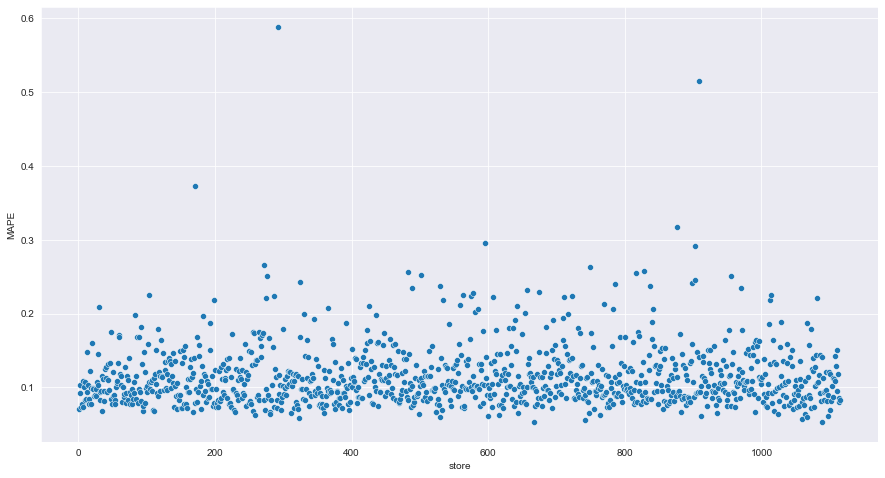

In [57]:
plt.figure( figsize=( 15, 8 ) )
sns.scatterplot( x='store', y='MAPE', data=df92, color=sns.color_palette('Paired')[1] )

## 9.1. Total Performace

The difference between the scenarios.

In [58]:
df93 = df92[['predictions','worst_scenarios','best_scenarios']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index':'Scenarios', 0:'Values'})
df93['Values'] = df93['Values'].map( 'R${:,.2f}'.format )
df93.head()

,Scenarios,Values
0,predictions,"R$287,260,416.00"
1,worst_scenarios,"R$286,409,667.53"
2,best_scenarios,"R$288,111,145.53"


## 9.1. Machine Learning Performace

In [60]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

C:\Users\Marcos\AppData\Local\Temp/ipykernel_2516/1385645114.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error'] = df9['sales'] - df9['predictions']
C:\Users\Marcos\AppData\Local\Temp/ipykernel_2516/1385645114.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error_rate'] = df9['predictions'] / df9['sales']


c:\users\marcos\projects\datascienceproduction\ds_production\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\marcos\projects\datascienceproduction\ds_production\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='predictions', ylabel='error'>

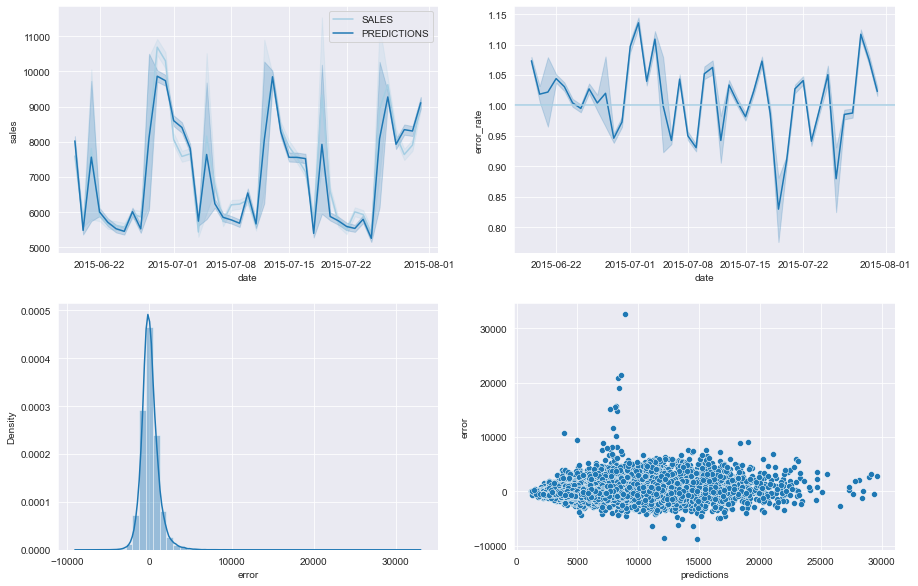

In [64]:
plt.figure( figsize=(15,10) )

plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9, color=sns.color_palette('Paired')[1] )
plt.axhline( 1 )

plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'], color=sns.color_palette('Paired')[1])

plt.subplot( 2, 2, 4 )
sns.scatterplot( df9['predictions'], df9['error'], color=sns.color_palette('Paired')[1] )

# 10.0 Deploy

## 10.1 Rossman Class

In [ ]:
# import pickle
# import inflection
# import pandas as pd
# import numpy as np
# import math
# import datetime

# class Rossmann( object ):
#     def __init__( self ):
#         self.home_path = 'C:/Users/Marcos/Projects/DataScienceProduction/'
#         self.competition_distance_scaler   = pickle.load( open( self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb') )
#         self.competition_time_month_scaler = pickle.load( open( self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb') )
#         self.promo_time_week_scaler        = pickle.load( open( self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb') )
#         self.year_scaler                   = pickle.load( open( self.home_path + 'parameter/year_scaler.pkl', 'rb') )
#         self.store_type_scaler             = pickle.load( open( self.home_path + 'parameter/store_type_scaler.pkl', 'rb') )
        
        
#     def data_cleaning( self, df1 ): 
        
#         ## 1.1. Rename Columns
#         cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
#                     'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
#                     'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

#         snakecase = lambda x: inflection.underscore( x )

#         cols_new = list( map( snakecase, cols_old ) )

#         # rename
#         df1.columns = cols_new

#         ## 1.3. Data Types
#         df1['date'] = pd.to_datetime( df1['date'] )

#         ## 1.5. Fillout NA
#         #competition_distance        
#         df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

#         #competition_open_since_month
#         df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

#         #competition_open_since_year 
#         df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

#         #promo2_since_week           
#         df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

#         #promo2_since_year           
#         df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

#         #promo_interval              
#         month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

#         df1['promo_interval'].fillna(0, inplace=True )

#         df1['month_map'] = df1['date'].dt.month.map( month_map )

#         df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

#         ## 1.6. Change Data Types
#         # competiton
#         df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
#         df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

#         # promo2
#         df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
#         df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )
        
#         return df1 


#     def feature_engineering( self, df2 ):

#         # year
#         df2['year'] = df2['date'].dt.year

#         # month
#         df2['month'] = df2['date'].dt.month

#         # day
#         df2['day'] = df2['date'].dt.day

#         # week of year
#         df2['week_of_year'] = df2['date'].dt.weekofyear

#         # year week
#         df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

#         # competition since
#         df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
#         df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

#         # promo since
#         df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
#         df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
#         df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

#         # assortment
#         df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

#         # state holiday
#         df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

#         # 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS
#         ## 3.1. Filtragem das Linhas
#         df2 = df2[df2['open'] != 0]

#         ## 3.2. Selecao das Colunas
#         cols_drop = ['open', 'promo_interval', 'month_map']
#         df2 = df2.drop( cols_drop, axis=1 )
        
#         return df2


#     def data_preparation( self, df5 ):

#         ## 5.2. Rescaling 
#         # competition distance
#         df5['competition_distance'] = self.competition_distance_scaler.fit_transform( df5[['competition_distance']].values )
    
#         # competition time month
#         df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform( df5[['competition_time_month']].values )

#         # promo time week
#         df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform( df5[['promo_time_week']].values )
        
#         # year
#         df5['year'] = self.year_scaler.fit_transform( df5[['year']].values )

#         ### 5.3.1. Encoding
#         # state_holiday - One Hot Encoding
#         df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

#         # store_type - Label Encoding
#         df5['store_type'] = self.store_type_scaler.fit_transform( df5['store_type'] )

#         # assortment - Ordinal Encoding
#         assortment_dict = {'basic': 1,  'extra': 2, 'extended': 3}
#         df5['assortment'] = df5['assortment'].map( assortment_dict )

        
#         ### 5.3.3. Nature Transformation
#         # day of week
#         df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
#         df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

#         # month
#         df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
#         df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

#         # day 
#         df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
#         df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

#         # week of year
#         df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
#         df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )
        
        
#         cols_selected = [ 'store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month',
#             'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week',
#             'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos']
        
#         return df5[ cols_selected ]
    
    
#     def get_prediction( self, model, original_data, test_data ):
#         # prediction
#         pred = model.predict( test_data )
        
#         # join pred into the original data
#         original_data['prediction'] = np.expm1( pred )
        
#         return original_data.to_json( orient='records', date_format='iso' )
        

## 10.1 API Handler

In [ ]:
# import pickle
# import pandas as pd
# from flask             import Flask, request, Response
# from rossmann.Rossmann import Rossmann

# # loading model
# model = pickle.load( open('C:/Users/Marcos/Projects/DataScienceProduction/model/model_rossmann.pkl', 'rb' ) )

# # initialize API
# app = Flask( __name__ )

# @app.route( '/rossmann/predict', methods=['POST'] )
# def rossmann_predict():
#     test_json = request.get_json()
   
#     if test_json: # there is data
#         if isinstance( test_json, dict ): # unique example
#             test_raw = pd.DataFrame( test_json, index=[0] )
            
#         else: # multiple example
#             test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
#         # Instantiate Rossmann class
#         pipeline = Rossmann()
        
#         # data cleaning
#         df1 = pipeline.data_cleaning( test_raw )
        
#         # feature engineering
#         df2 = pipeline.feature_engineering( df1 )
        
#         # data preparation
#         df3 = pipeline.data_preparation( df2 )
        
#         # prediction
#         df_response = pipeline.get_prediction( model, test_raw, df3 )
        
#         return df_response
        
        
#     else:
#         return Response( '{}', status=200, mimetype='application/json' )

# if __name__ == '__main__':
#     app.run( '0.0.0.0' )

## 10.1 API Test

In [5]:
df10 = pd.read_csv( 'data/test.csv' )
df_test = pd.merge( df10, df_store_raw, how='left', on='Store' )

df_test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,1,4,2015-09-17,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,3,4,2015-09-17,1.0,1,0,0,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
2,3,7,4,2015-09-17,1.0,1,0,0,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
3,4,8,4,2015-09-17,1.0,1,0,0,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
4,5,9,4,2015-09-17,1.0,1,0,0,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN


In [6]:
# choose store for predictions
df_test = df_test[df_test['Store'].isin( [20, 14, 21] )]

# remove cose days
df_test = df_test[ df_test['Open'] != 0 ]
df_test = df_test[ ~df_test['Open'].isnull() ]
df_test = df_test.drop( 'Id', axis=1 )

# convert dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [7]:
# API Call
# url = 'http://192.168.0.109:5000/rossmann/predict'
url = 'https://rossmann-predict-model-test.herokuapp.com/rossmann/predict'
header = {'Content-type': 'application/json' } 
data = data

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

Status Code 200


In [8]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys())
d1.head()

,store,day_of_week,date,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,prediction
0,14,4,2015-09-17T00:00:00.000Z,1.0,1,regular_day,0,a,basic,1300.0,...,2015,9,17,38,2015-37,2014-03-01T00:00:00.000Z,18,2011-09-26T00:00:00.000Z,207,5626.989746
1,20,4,2015-09-17T00:00:00.000Z,1.0,1,regular_day,0,d,basic,2340.0,...,2015,9,17,38,2015-37,2009-05-01T00:00:00.000Z,77,2014-09-29T00:00:00.000Z,50,7038.315918
2,21,4,2015-09-17T00:00:00.000Z,1.0,1,regular_day,0,c,extended,550.0,...,2015,9,17,38,2015-37,1999-10-01T00:00:00.000Z,194,2009-11-02T00:00:00.000Z,306,6312.589844
3,14,3,2015-09-16T00:00:00.000Z,1.0,1,regular_day,0,a,basic,1300.0,...,2015,9,16,38,2015-37,2014-03-01T00:00:00.000Z,18,2011-09-26T00:00:00.000Z,207,5724.756836
4,20,3,2015-09-16T00:00:00.000Z,1.0,1,regular_day,0,d,basic,2340.0,...,2015,9,16,38,2015-37,2009-05-01T00:00:00.000Z,77,2014-09-29T00:00:00.000Z,50,7165.443848


In [9]:
d2 = d1[['store','prediction']].groupby('store').sum().reset_index()

for i in range( len(d2) ):
    print( 'Store Number {} will sell R${:,.2f} in the next 6 weeks' .format(
    d2.loc[i, 'store'],
    d2.loc[i,'prediction'] ) )

Store Number 14 will sell R$206,507.51 in the next 6 weeks
Store Number 20 will sell R$268,432.51 in the next 6 weeks
Store Number 21 will sell R$247,883.81 in the next 6 weeks
